In [1]:
import os
import torch
from torch import nn
from torch.optim import Adam
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

class IXIDataSet(Dataset):

    def __init__(self, main_path, transform):
        self.main_path = main_path
        self.transform = transform
        self.image_paths = [os.path.join(main_path, case_path, image) for case_path in os.listdir(main_path) for image in os.listdir(os.path.join(main_path, case_path))]
        self.image_paths = self.image_paths[:5000]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path)

        if self.transform is not None:
            image = self.transform(image)

        return image


In [2]:
def sampling(mean, log_var):
    """
    Samples from the latent distribution using the reparameterization trick, allowing gradients to flow through
    stochastic nodes.

    :param mean: Tensor representing the mean of the latent distribution, shape (batch_size, latent_dim)
    :param log_var: Tensor representing the log variance of the latent distribution, shape (batch_size, latent_dim)
    :return: Sampled latent vector z, tensor of shape (batch_size, latent_dim)
    """
    epsilon = torch.randn_like(mean)
    z = mean + torch.exp(log_var * 0.5) * epsilon
    return z


def plot_loss(loss_list, name):
    """
    Plots the loss over the training iterations.

    :param loss_list: List of loss values to plot
    :param name: Name of the loss being plotted
    """
    plt.figure(figsize=(10, 5))
    plt.title(f"{name} During Training")
    plt.plot(loss_list, label=f"{name}")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


class Encoder(nn.Module):
    """
    Encoder module for the VAE. Compresses input images into a latent space represented by mean and log variance.
    """
    def __init__(self, latent_dim=1024):
        """
        Initializes the Encoder layers.

        :param latent_dim: Dimensionality of the latent space
        """
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv0 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.bn0 = nn.BatchNorm2d(16)
        self.conv1 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)        
        self.bn5 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.mean = nn.Linear(8192, 1024)
        self.log_var = nn.Linear(8192, 1024)

    def forward(self, x):
        """
        Forward pass through the Encoder to obtain mean and log variance for the latent space.

        :param x: Input tensor of shape (batch_size, channels, height, width)
        :return: Mean and log variance tensors of shape (batch_size, latent_dim)
        """
        batch_size = x.size(0)
        x = self.relu(self.dropout(self.bn0(self.conv0(x))))
        x = self.relu(self.dropout(self.bn1(self.conv1(x))))
        x = self.relu(self.dropout(self.bn2(self.conv2(x))))
        x = self.relu(self.dropout(self.bn3(self.conv3(x))))
        x = self.relu(self.dropout(self.bn4(self.conv4(x))))
        x = self.relu(self.dropout(self.bn5(self.conv5(x))))
        x = x.view(batch_size, -1)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var


class Decoder(nn.Module):
    """
    Decoder module for the VAE. Reconstructs images from the latent representation.
    """

    def __init__(self):
        """
        Initializes the Decoder layers.
        """
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(1024, 8192)
        self.bn1 = nn.BatchNorm1d(8192)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.deconv1 = nn.ConvTranspose2d(512, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.deconv6 = nn.ConvTranspose2d(16, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.tanh = nn.Tanh()

    def forward(self, x):
        """
        Forward pass through the Decoder to reconstruct the input images from the latent vector.

        :param x: Latent representation tensor, shape (batch_size, latent_dim)
        :return: Reconstructed image tensor, shape (batch_size, channels, height, width)
        """
        batch_size = x.size(0)
        x = self.relu(self.fc1(x))
        x = x.view(batch_size, 512, 4, 4)
        x = self.relu(self.dropout(self.bn2(self.deconv1(x))))
        x = self.relu(self.dropout(self.bn3(self.deconv2(x))))
        x = self.relu(self.dropout(self.bn4(self.deconv3(x))))
        x = self.relu(self.dropout(self.bn5(self.deconv4(x))))
        x = self.relu(self.dropout(self.bn6(self.deconv5(x))))
        x = self.tanh(self.deconv6(x))
        return x


class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) combining Encoder and Decoder modules to learn a latent representation of input data.
    """

    def __init__(self, encoder, decoder):
        """
        Initializes the VAE with an encoder, decoder, and latent dimension.

        :param encoder: Encoder module
        :param decoder: Decoder module
        :param z_dim: Dimensionality of the latent space
        """
        super(VAE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.recon_loss_list = []
        self.kl_loss_list = []
        self.epoch_loss_list = []
        self.val_recon_loss_list = []
        self.val_kl_loss_list = []
        self.val_epoch_loss_list = []

    def loss_function(self, reconstruction, x, mean, log_var):
        """
        Computes the VAE loss, combining reconstruction and KL divergence losses.

        :param reconstruction: Reconstructed images, shape (batch_size, channels, height, width)
        :param x: Original images, shape (batch_size, channels, height, width)
        :param mean: Latent mean tensor, shape (batch_size, latent_dim)
        :param log_var: Latent log variance tensor, shape (batch_size, latent_dim)
        :return: Total loss, KL divergence, and reconstruction loss
        """
        # recon_loss = ((reconstruction - x) ** 2).sum()
        recon_loss = torch.nn.MSELoss(reduction='sum')(reconstruction, x)
        kl_div = (-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0))
        total_loss = recon_loss + kl_div
        return total_loss, kl_div, recon_loss

    def forward(self, x):
        """
        Forward pass through the VAE. Encodes the input, samples from the latent distribution, and decodes.

        :param x: Input images, shape (batch_size, channels, height, width)
        :return: Reconstructed images, mean, and log variance tensors
        """
        mean, log_var = self.encoder(x)
        z = sampling(mean, log_var)
        reconstruction = self.decoder(z)
        return reconstruction, mean, log_var

    def train_vae(self, train_dataloader, val_dataloader=None, epochs=20, lr=0.0005, device='cuda'):
        """
        Trains the VAE, with optional validation.

        :param train_dataloader: DataLoader for training data
        :param val_dataloader: DataLoader for validation data (optional)
        :param epochs: Number of training epochs
        :param lr: Learning rate for the optimizer
        :param device: Device to use for training (e.g., 'cuda' or 'cpu')
        """
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        for epoch in range(epochs):
            train_dataloader_with_progress = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
            total_epoch_loss, kl_epoch_loss, recon_epoch_loss = 0, 0, 0
            self.train()
            for data in train_dataloader_with_progress:
                data = data.to(device)
                optimizer.zero_grad()
                reconstruction, mean, log_var = self.forward(data)
                loss, kl_loss, recon_loss = self.loss_function(reconstruction, data, mean, log_var)
                loss.backward()
                optimizer.step()
                total_epoch_loss += loss.item()
                kl_epoch_loss += kl_loss.item()
                recon_epoch_loss += recon_loss.item()

            total_epoch_loss /= len(train_dataloader)
            kl_epoch_loss /= len(train_dataloader)
            recon_epoch_loss /= len(train_dataloader)
            
            self.epoch_loss_list.append(total_epoch_loss)
            self.kl_loss_list.append(kl_epoch_loss)
            self.recon_loss_list.append(recon_epoch_loss)
            print(f"Training - Epoch [{epoch+1}/{epochs}], Total Loss: {total_epoch_loss:.4f}, KL Loss: {kl_epoch_loss:.4f}, Recon Loss: {recon_epoch_loss:.4f}")
            if val_dataloader:
                self.eval()
                val_total_epoch_loss, val_kl_epoch_loss, val_recon_epoch_loss = 0, 0, 0
                with torch.no_grad():
                    for data in val_dataloader:
                        data = data.to(device)
                        reconstruction, mean, log_var = self.forward(data)
                        loss, kl_loss, recon_loss = self.loss_function(reconstruction, data, mean, log_var)
                        val_total_epoch_loss += loss.item()
                        val_kl_epoch_loss += kl_loss.item()
                        val_recon_epoch_loss += recon_loss.item()

                val_total_epoch_loss /= len(val_dataloader)
                val_kl_epoch_loss /= len(val_dataloader)
                val_recon_epoch_loss /= len(val_dataloader)
                                        
                self.val_epoch_loss_list.append(val_total_epoch_loss)
                self.val_kl_loss_list.append(val_kl_epoch_loss)
                self.val_recon_loss_list.append(val_recon_epoch_loss)
                print(f"Validation - Epoch [{epoch+1}/{epochs}], Total Loss: {val_total_epoch_loss:.4f}, KL Loss: {val_kl_epoch_loss:.4f}, Recon Loss: {val_recon_epoch_loss:.4f}")
        plot_loss(self.epoch_loss_list, "Training Total Loss")
        plot_loss(self.kl_loss_list, "Training KL Loss")
        plot_loss(self.recon_loss_list, "Training Reconstruction Loss")
        if val_dataloader:
            plot_loss(self.val_epoch_loss_list, "Validation Total Loss")
            plot_loss(self.val_kl_loss_list, "Validation KL Loss")
            plot_loss(self.val_recon_loss_list, "Validation Reconstruction Loss")


In [3]:
# Path to directory containing face images
main_path = '/kaggle/input/ixit2-slices/image slice-T2'

# Device configuration (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Batch size for data loading
batch_size = 128


def save_model(model, path='./vae_model.pth'):
    """
    Saves the VAE model, including encoder, decoder, and other parameters.

    :param model: VAE model to save
    :param path: Path to save the model parameters
    """
    # Save model state dictionaries for encoder, decoder, and full VAE
    torch.save({
        'encoder_state_dict': model.encoder.state_dict(),
        'decoder_state_dict': model.decoder.state_dict(),
        'vae_state_dict': model.state_dict(),
        'latent_dim': model.encoder.latent_dim
    }, path)
    print(f"Model saved to {path}")

def show_samples(samples, nrows=2, ncols=5):
    """
    Displays a grid of images from sample tensors.

    :param samples: Tensor of images to display, shape (num_samples, channels, height, width)
    :param nrows: Number of rows in the grid
    :param ncols: Number of columns in the grid
    """
    samples = samples.cpu().numpy()
    fig, axes = plt.subplots(nrows, ncols, figsize=(15, 15))
    axes = axes.flatten()

    for i in range(len(samples)):
        # axes[i].imshow(samples[i].transpose(1, 2, 0) * 0.5 + 0.5)
        axes[i].imshow(samples[i].squeeze(0), cmap='gray')
        axes[i].axis('off')

    plt.show()


# Define image transformations for pre-processing
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

# Load dataset and split into training and validation sets
trainset = IXIDataSet(main_path, transform=transform)
trainset, valset = train_test_split(trainset, test_size=0.2, random_state=42)


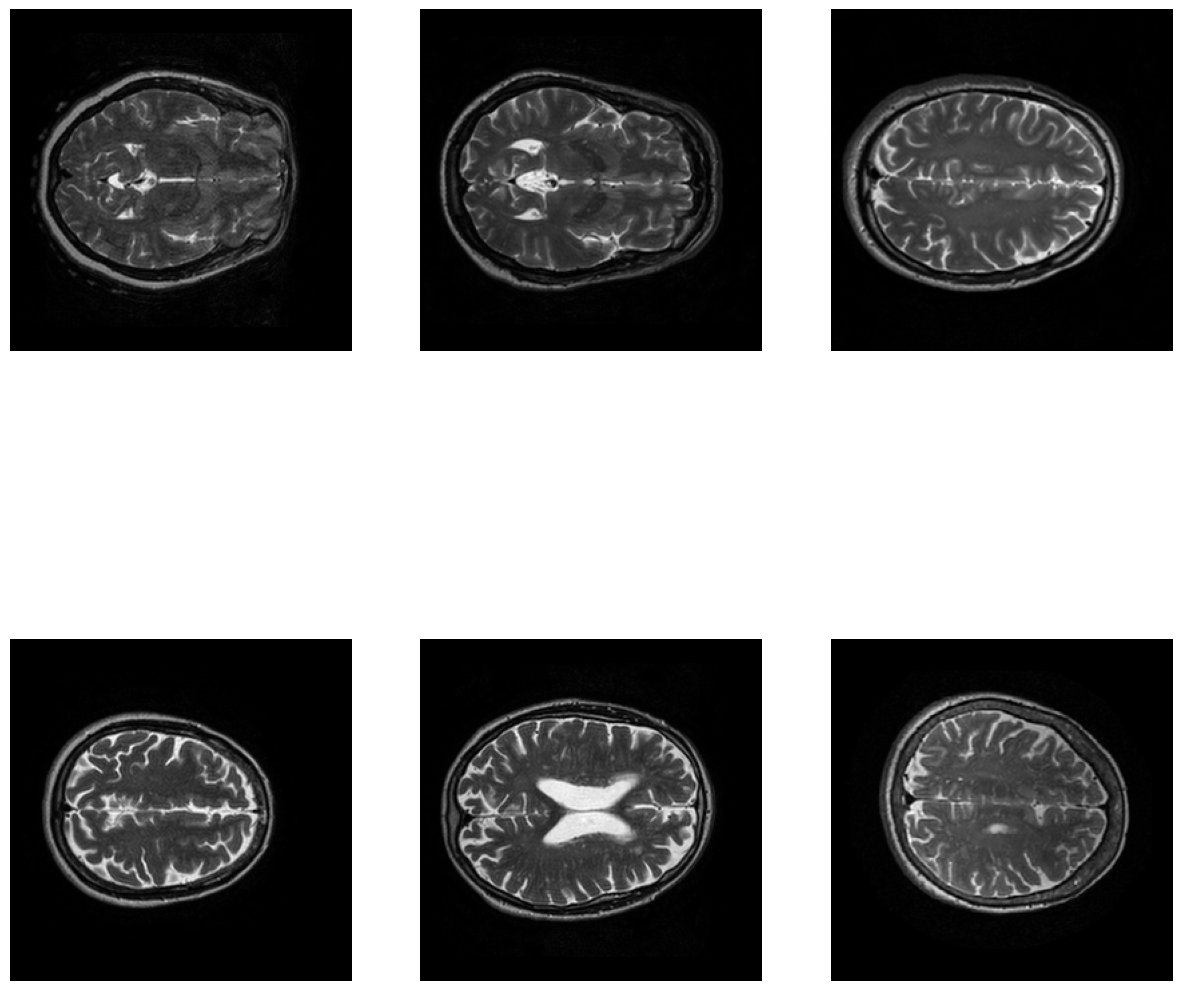

In [4]:
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=3)
valloader = DataLoader(valset, batch_size=64, shuffle=False, num_workers=3)

data_iter = iter(trainloader)
images = next(data_iter)
random_images = images[:6]
show_samples(random_images, nrows=2, ncols=3)


Epoch 1/50: 100%|██████████| 63/63 [00:07<00:00,  8.15it/s]

Training - Epoch [1/50], Total Loss: 1741164.1200, KL Loss: 52721.6295, Recon Loss: 1688442.4911


Validation - Epoch [1/50], Total Loss: 645108.4199, KL Loss: 139093.0938, Recon Loss: 506015.3320


Epoch 2/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [2/50], Total Loss: 477288.4308, KL Loss: 33217.1625, Recon Loss: 444071.2688


Validation - Epoch [2/50], Total Loss: 278204.4326, KL Loss: 19649.2422, Recon Loss: 258555.1895


Epoch 3/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [3/50], Total Loss: 307103.8172, KL Loss: 22143.3005, Recon Loss: 284960.5164


Validation - Epoch [3/50], Total Loss: 237438.1895, KL Loss: 14100.0198, Recon Loss: 223338.1709


Epoch 4/50: 100%|██████████| 63/63 [00:06<00:00,  9.62it/s]

Training - Epoch [4/50], Total Loss: 280516.7123, KL Loss: 31583.8946, Recon Loss: 248932.8186


Validation - Epoch [4/50], Total Loss: 237887.2686, KL Loss: 39279.2717, Recon Loss: 198607.9990


Epoch 5/50: 100%|██████████| 63/63 [00:06<00:00,  9.56it/s]

Training - Epoch [5/50], Total Loss: 232640.6281, KL Loss: 10252.8167, Recon Loss: 222387.8113


Validation - Epoch [5/50], Total Loss: 192276.1816, KL Loss: 4163.1013, Recon Loss: 188113.0806


Epoch 6/50: 100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Training - Epoch [6/50], Total Loss: 216528.5962, KL Loss: 7168.4651, Recon Loss: 209360.1316


Validation - Epoch [6/50], Total Loss: 185414.6670, KL Loss: 4662.5281, Recon Loss: 180752.1392


Epoch 7/50: 100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Training - Epoch [7/50], Total Loss: 204248.9149, KL Loss: 7598.3064, Recon Loss: 196650.6088


Validation - Epoch [7/50], Total Loss: 178329.4976, KL Loss: 7911.0729, Recon Loss: 170418.4253


Epoch 8/50: 100%|██████████| 63/63 [00:06<00:00,  9.59it/s]

Training - Epoch [8/50], Total Loss: 195862.5645, KL Loss: 9056.7112, Recon Loss: 186805.8542


Validation - Epoch [8/50], Total Loss: 174494.8599, KL Loss: 5770.8820, Recon Loss: 168723.9795


Epoch 9/50: 100%|██████████| 63/63 [00:06<00:00,  9.56it/s]

Training - Epoch [9/50], Total Loss: 184859.5433, KL Loss: 6928.6526, Recon Loss: 177930.8906


Validation - Epoch [9/50], Total Loss: 163300.0605, KL Loss: 5557.9330, Recon Loss: 157742.1289


Epoch 10/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [10/50], Total Loss: 181625.8925, KL Loss: 8283.9012, Recon Loss: 173341.9911


Validation - Epoch [10/50], Total Loss: 164002.1631, KL Loss: 5457.2020, Recon Loss: 158544.9609


Epoch 11/50: 100%|██████████| 63/63 [00:06<00:00,  9.61it/s]

Training - Epoch [11/50], Total Loss: 178276.9633, KL Loss: 8762.6855, Recon Loss: 169514.2775


Validation - Epoch [11/50], Total Loss: 163538.2183, KL Loss: 6929.5588, Recon Loss: 156608.6572


Epoch 12/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [12/50], Total Loss: 170777.9896, KL Loss: 7338.7925, Recon Loss: 163439.1967


Validation - Epoch [12/50], Total Loss: 160871.0981, KL Loss: 6289.6289, Recon Loss: 154581.4688


Epoch 13/50: 100%|██████████| 63/63 [00:06<00:00,  9.59it/s]

Training - Epoch [13/50], Total Loss: 167198.0030, KL Loss: 7510.0496, Recon Loss: 159687.9526


Validation - Epoch [13/50], Total Loss: 152195.8652, KL Loss: 6040.7160, Recon Loss: 146155.1499


Epoch 14/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [14/50], Total Loss: 164392.1217, KL Loss: 7943.2284, Recon Loss: 156448.8935


Validation - Epoch [14/50], Total Loss: 144165.7100, KL Loss: 7299.0693, Recon Loss: 136866.6392


Epoch 15/50: 100%|██████████| 63/63 [00:06<00:00,  9.54it/s]

Training - Epoch [15/50], Total Loss: 159280.2592, KL Loss: 7773.0493, Recon Loss: 151507.2091


Validation - Epoch [15/50], Total Loss: 143854.7783, KL Loss: 7486.8794, Recon Loss: 136367.9004


Epoch 16/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [16/50], Total Loss: 156706.9422, KL Loss: 8212.2842, Recon Loss: 148494.6585


Validation - Epoch [16/50], Total Loss: 142427.9717, KL Loss: 7487.5414, Recon Loss: 134940.4307


Epoch 17/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [17/50], Total Loss: 154476.8730, KL Loss: 8338.1649, Recon Loss: 146138.7073


Validation - Epoch [17/50], Total Loss: 137550.5376, KL Loss: 7955.5912, Recon Loss: 129594.9448


Epoch 18/50: 100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Training - Epoch [18/50], Total Loss: 150984.0556, KL Loss: 8485.4266, Recon Loss: 142498.6284


Validation - Epoch [18/50], Total Loss: 137374.8442, KL Loss: 7945.2667, Recon Loss: 129429.5776


Epoch 19/50: 100%|██████████| 63/63 [00:06<00:00,  9.59it/s]

Training - Epoch [19/50], Total Loss: 148086.7321, KL Loss: 8369.4891, Recon Loss: 139717.2432


Validation - Epoch [19/50], Total Loss: 138104.1245, KL Loss: 8548.3199, Recon Loss: 129555.8062


Epoch 20/50: 100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Training - Epoch [20/50], Total Loss: 145970.2400, KL Loss: 8537.4495, Recon Loss: 137432.7894


Validation - Epoch [20/50], Total Loss: 135430.1250, KL Loss: 8557.3192, Recon Loss: 126872.8062


Epoch 21/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [21/50], Total Loss: 145455.8734, KL Loss: 8958.8762, Recon Loss: 136496.9970


Validation - Epoch [21/50], Total Loss: 128591.9346, KL Loss: 8497.9074, Recon Loss: 120094.0273


Epoch 22/50: 100%|██████████| 63/63 [00:06<00:00,  9.60it/s]

Training - Epoch [22/50], Total Loss: 141439.2494, KL Loss: 8436.0120, Recon Loss: 133003.2378


Validation - Epoch [22/50], Total Loss: 124457.6470, KL Loss: 8189.6242, Recon Loss: 116268.0229


Epoch 23/50: 100%|██████████| 63/63 [00:06<00:00,  9.59it/s]

Training - Epoch [23/50], Total Loss: 138442.3436, KL Loss: 8330.6698, Recon Loss: 130111.6732


Validation - Epoch [23/50], Total Loss: 123661.9653, KL Loss: 8089.3685, Recon Loss: 115572.5967


Epoch 24/50: 100%|██████████| 63/63 [00:06<00:00,  9.60it/s]

Training - Epoch [24/50], Total Loss: 135867.2044, KL Loss: 8256.2224, Recon Loss: 127610.9819


Validation - Epoch [24/50], Total Loss: 119334.7886, KL Loss: 8263.2850, Recon Loss: 111071.5039


Epoch 25/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [25/50], Total Loss: 134683.7563, KL Loss: 8488.9818, Recon Loss: 126194.7738


Validation - Epoch [25/50], Total Loss: 118980.1860, KL Loss: 8512.7386, Recon Loss: 110467.4478


Epoch 26/50: 100%|██████████| 63/63 [00:06<00:00,  9.51it/s]

Training - Epoch [26/50], Total Loss: 133165.8746, KL Loss: 8291.2366, Recon Loss: 124874.6389


Validation - Epoch [26/50], Total Loss: 118470.4497, KL Loss: 8377.8168, Recon Loss: 110092.6333


Epoch 27/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [27/50], Total Loss: 131449.0543, KL Loss: 8275.7639, Recon Loss: 123173.2904


Validation - Epoch [27/50], Total Loss: 117208.6704, KL Loss: 8562.1953, Recon Loss: 108646.4751


Epoch 28/50: 100%|██████████| 63/63 [00:06<00:00,  9.54it/s]

Training - Epoch [28/50], Total Loss: 128783.0324, KL Loss: 8159.7029, Recon Loss: 120623.3294


Validation - Epoch [28/50], Total Loss: 114942.6704, KL Loss: 8625.4462, Recon Loss: 106317.2251


Epoch 29/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [29/50], Total Loss: 127892.9871, KL Loss: 8044.2180, Recon Loss: 119848.7690


Validation - Epoch [29/50], Total Loss: 115805.6099, KL Loss: 7911.0880, Recon Loss: 107894.5200


Epoch 30/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [30/50], Total Loss: 126822.9629, KL Loss: 8152.9944, Recon Loss: 118669.9683


Validation - Epoch [30/50], Total Loss: 114113.0137, KL Loss: 8017.2901, Recon Loss: 106095.7246


Epoch 31/50: 100%|██████████| 63/63 [00:06<00:00,  9.61it/s]

Training - Epoch [31/50], Total Loss: 124920.7247, KL Loss: 8026.9863, Recon Loss: 116893.7387


Validation - Epoch [31/50], Total Loss: 110923.0356, KL Loss: 8311.8587, Recon Loss: 102611.1772


Epoch 32/50: 100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Training - Epoch [32/50], Total Loss: 123869.8745, KL Loss: 8077.9125, Recon Loss: 115791.9617


Validation - Epoch [32/50], Total Loss: 109075.2026, KL Loss: 8272.3319, Recon Loss: 100802.8721


Epoch 33/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [33/50], Total Loss: 121981.1623, KL Loss: 7945.3513, Recon Loss: 114035.8110


Validation - Epoch [33/50], Total Loss: 108810.2339, KL Loss: 8224.2127, Recon Loss: 100586.0215


Epoch 34/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [34/50], Total Loss: 121751.9353, KL Loss: 8029.3976, Recon Loss: 113722.5380


Validation - Epoch [34/50], Total Loss: 108073.0518, KL Loss: 8252.3799, Recon Loss: 99820.6721


Epoch 35/50: 100%|██████████| 63/63 [00:06<00:00,  9.49it/s]

Training - Epoch [35/50], Total Loss: 119972.5678, KL Loss: 7956.0033, Recon Loss: 112016.5647


Validation - Epoch [35/50], Total Loss: 106388.2266, KL Loss: 8248.5745, Recon Loss: 98139.6526


Epoch 36/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [36/50], Total Loss: 118746.8635, KL Loss: 7942.6978, Recon Loss: 110804.1657


Validation - Epoch [36/50], Total Loss: 106139.1973, KL Loss: 8569.3961, Recon Loss: 97569.8005


Epoch 37/50: 100%|██████████| 63/63 [00:06<00:00,  9.55it/s]

Training - Epoch [37/50], Total Loss: 117588.7769, KL Loss: 7881.9692, Recon Loss: 109706.8074


Validation - Epoch [37/50], Total Loss: 105449.8652, KL Loss: 8475.5665, Recon Loss: 96974.2983


Epoch 38/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [38/50], Total Loss: 116856.1143, KL Loss: 7916.5473, Recon Loss: 108939.5672


Validation - Epoch [38/50], Total Loss: 103175.5176, KL Loss: 8604.8223, Recon Loss: 94570.6951


Epoch 39/50: 100%|██████████| 63/63 [00:06<00:00,  9.56it/s]

Training - Epoch [39/50], Total Loss: 115960.1761, KL Loss: 7818.8804, Recon Loss: 108141.2958


Validation - Epoch [39/50], Total Loss: 104087.0547, KL Loss: 7704.7945, Recon Loss: 96382.2583


Epoch 40/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [40/50], Total Loss: 114810.3842, KL Loss: 7828.7027, Recon Loss: 106981.6815


Validation - Epoch [40/50], Total Loss: 101957.8501, KL Loss: 8002.2170, Recon Loss: 93955.6338


Epoch 41/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [41/50], Total Loss: 114022.8550, KL Loss: 8054.7492, Recon Loss: 105968.1059


Validation - Epoch [41/50], Total Loss: 101685.3472, KL Loss: 8436.6147, Recon Loss: 93248.7339


Epoch 42/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [42/50], Total Loss: 113258.0257, KL Loss: 7784.0936, Recon Loss: 105473.9318


Validation - Epoch [42/50], Total Loss: 100282.6252, KL Loss: 7387.8614, Recon Loss: 92894.7639


Epoch 43/50: 100%|██████████| 63/63 [00:06<00:00,  9.53it/s]

Training - Epoch [43/50], Total Loss: 112234.3805, KL Loss: 7768.9144, Recon Loss: 104465.4663


Validation - Epoch [43/50], Total Loss: 100313.4443, KL Loss: 7419.8210, Recon Loss: 92893.6233


Epoch 44/50: 100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Training - Epoch [44/50], Total Loss: 111498.5717, KL Loss: 7891.5208, Recon Loss: 103607.0507


Validation - Epoch [44/50], Total Loss: 99583.0288, KL Loss: 7916.2167, Recon Loss: 91666.8120


Epoch 45/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [45/50], Total Loss: 110817.4720, KL Loss: 7829.5175, Recon Loss: 102987.9548


Validation - Epoch [45/50], Total Loss: 99466.2493, KL Loss: 8237.6788, Recon Loss: 91228.5703


Epoch 46/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [46/50], Total Loss: 110096.8176, KL Loss: 7786.7693, Recon Loss: 102310.0482


Validation - Epoch [46/50], Total Loss: 98798.7126, KL Loss: 8466.2823, Recon Loss: 90332.4302


Epoch 47/50: 100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Training - Epoch [47/50], Total Loss: 109302.8229, KL Loss: 7797.6472, Recon Loss: 101505.1755


Validation - Epoch [47/50], Total Loss: 97647.1907, KL Loss: 7680.3636, Recon Loss: 89966.8271


Epoch 48/50: 100%|██████████| 63/63 [00:06<00:00,  9.57it/s]

Training - Epoch [48/50], Total Loss: 108704.5570, KL Loss: 7905.9923, Recon Loss: 100798.5650


Validation - Epoch [48/50], Total Loss: 96874.4646, KL Loss: 7016.4186, Recon Loss: 89858.0454


Epoch 49/50: 100%|██████████| 63/63 [00:06<00:00,  9.52it/s]

Training - Epoch [49/50], Total Loss: 107911.2064, KL Loss: 7796.8871, Recon Loss: 100114.3196


Validation - Epoch [49/50], Total Loss: 96429.6799, KL Loss: 7746.9882, Recon Loss: 88682.6917


Epoch 50/50: 100%|██████████| 63/63 [00:06<00:00,  9.58it/s]

Training - Epoch [50/50], Total Loss: 107142.6939, KL Loss: 7697.2568, Recon Loss: 99445.4370


Validation - Epoch [50/50], Total Loss: 95311.1479, KL Loss: 7515.8485, Recon Loss: 87795.2993


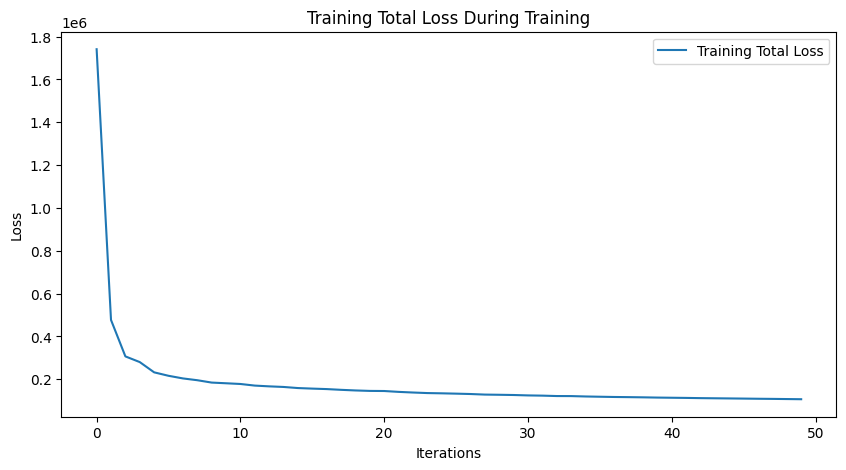

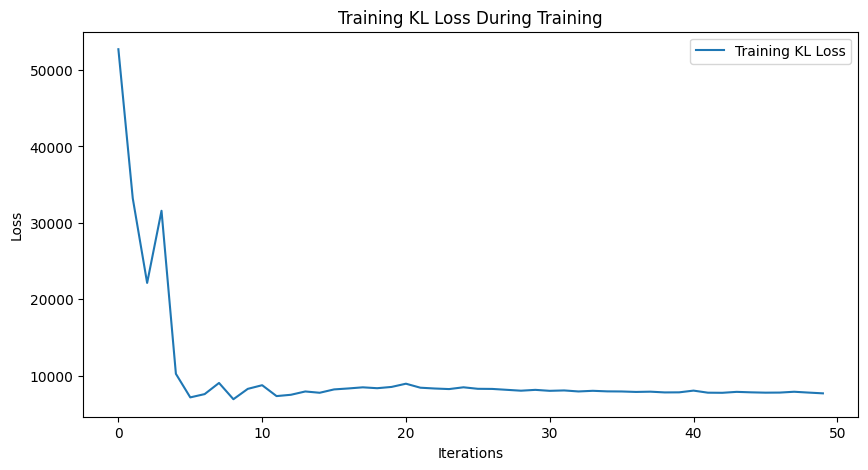

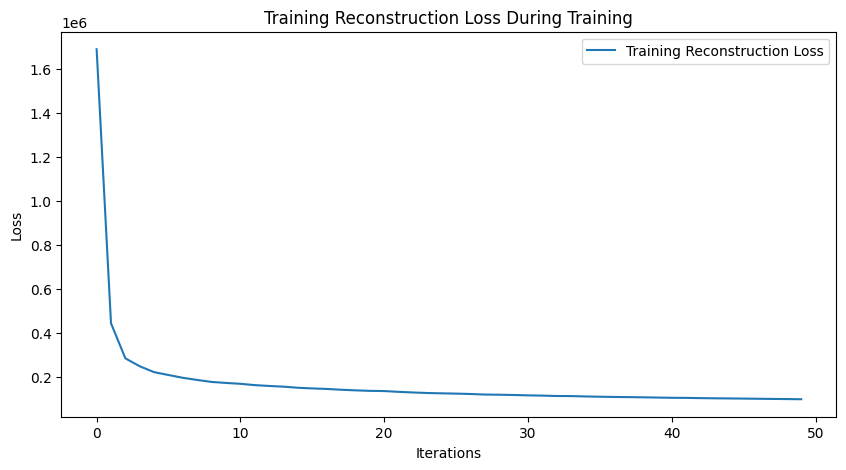

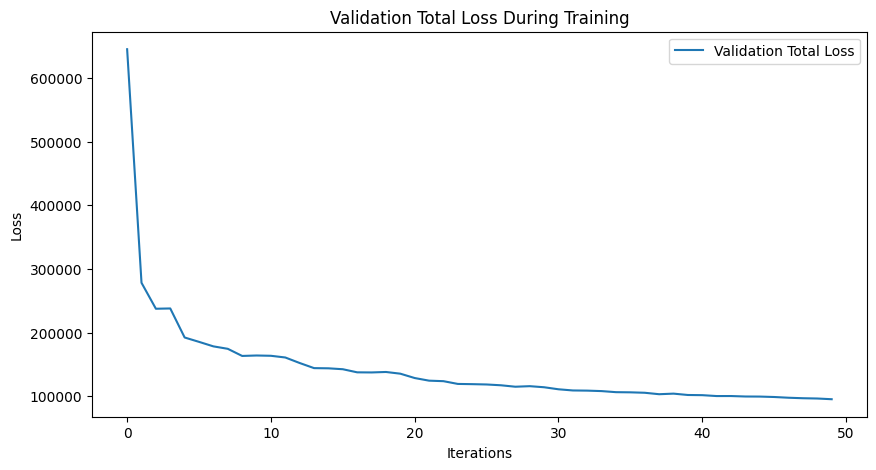

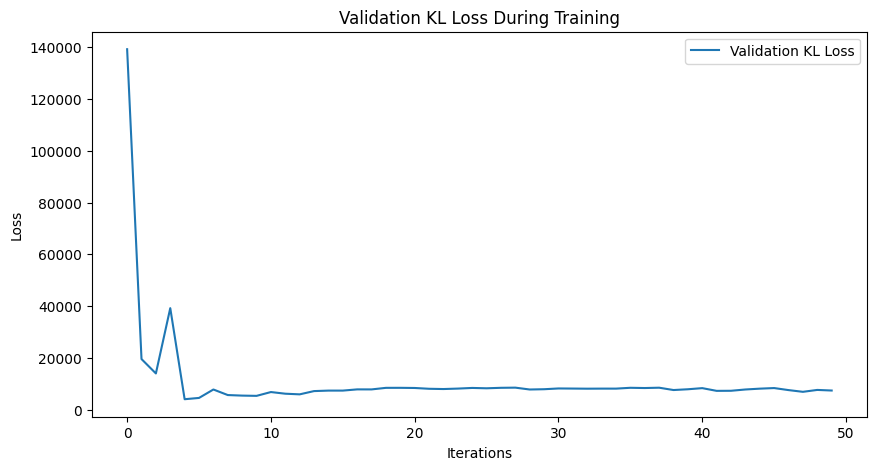

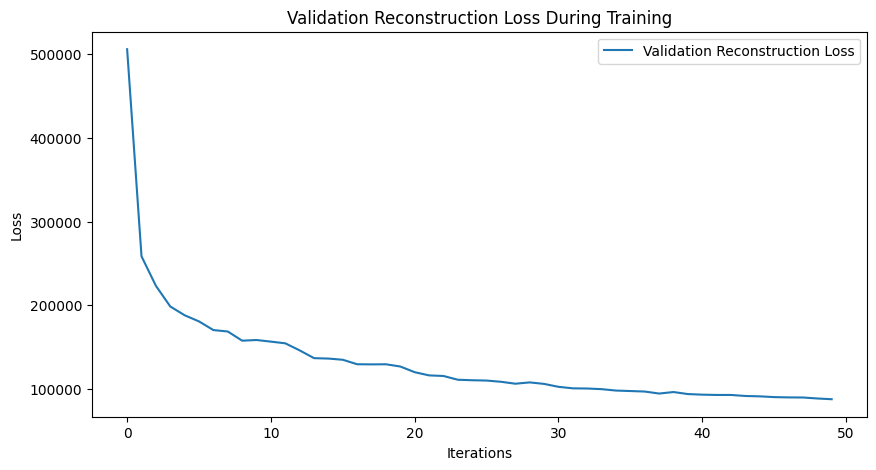

Model saved to ./vae_model.pth


In [5]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
vae = VAE(encoder, decoder).to(device)

# Train the VAE model
vae.train_vae(trainloader, valloader, epochs=50)

# Save the trained VAE model
save_model(vae)


Real Images:


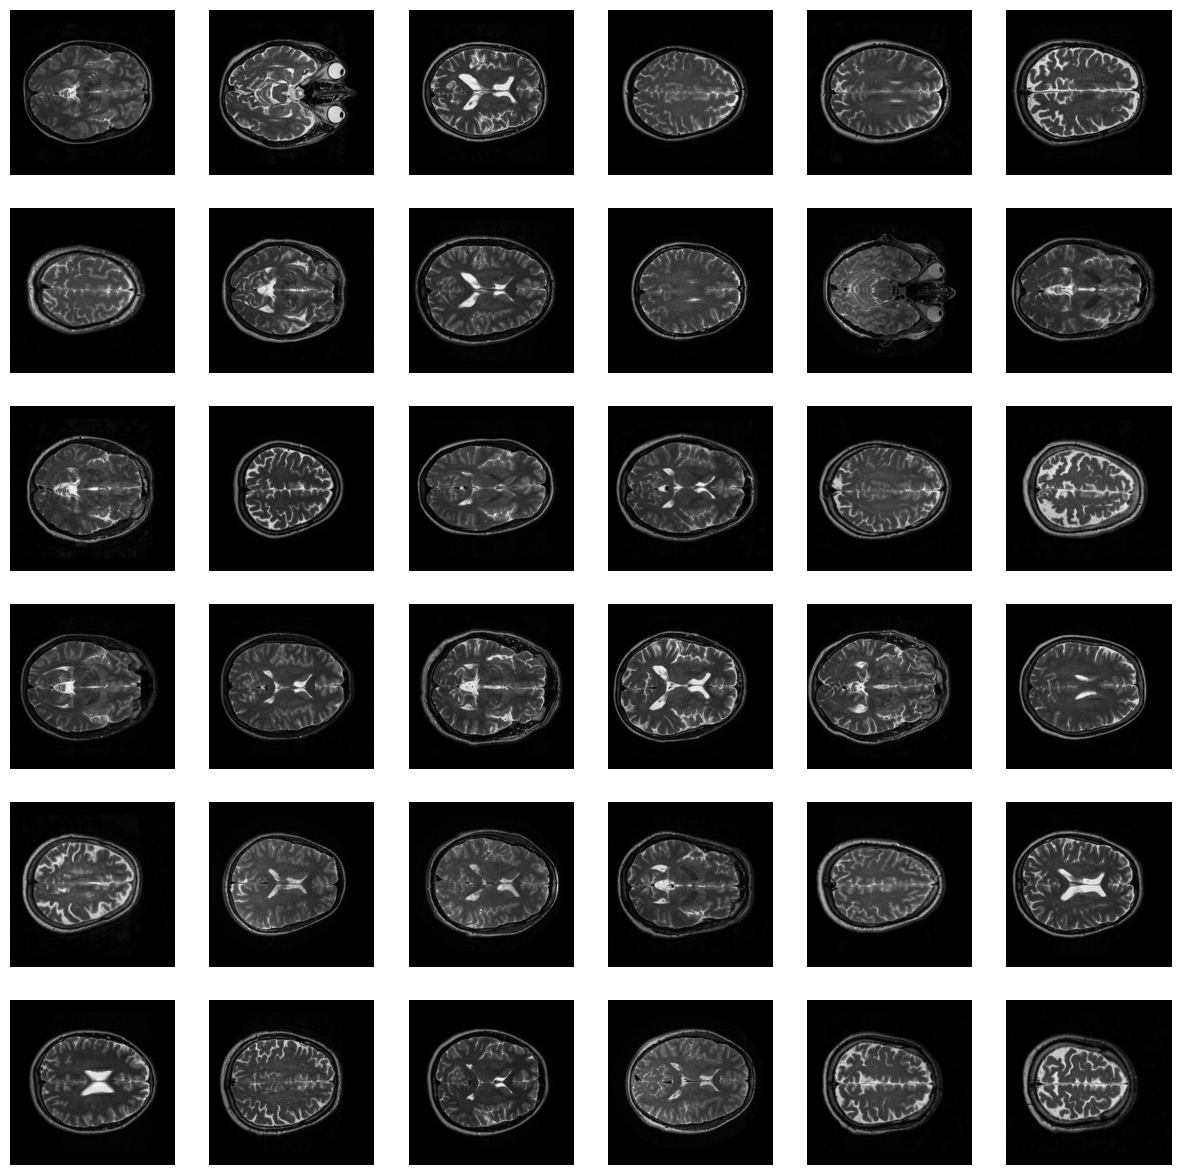

Reconstructed Images:


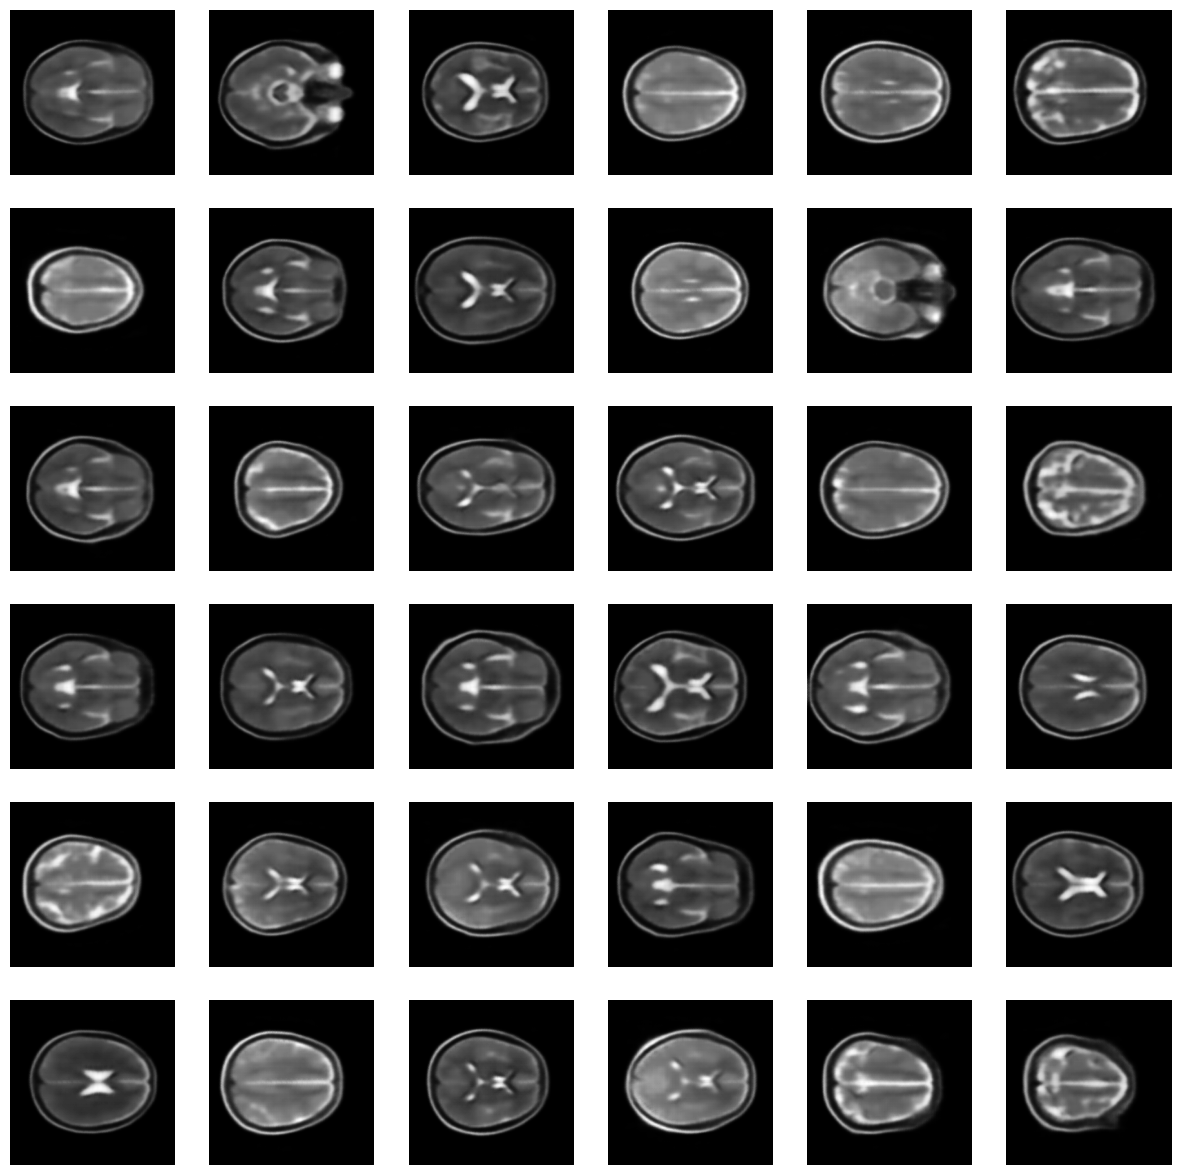

In [6]:
def encoded_real_samples(model, device='cuda', batch_size=128):
    """
    Encodes real samples from a dataset and displays the decoded output.

    :param model: VAE model to encode and decode the samples
    :param device: Device to use for processing ('cuda' or 'cpu')
    :param batch_size: Number of samples to process in a batch
    """
    data_iter = iter(trainloader)
    samples = next(data_iter)
    samples = samples[:36]
    samples = samples.to(device)

    model.eval()
    with torch.no_grad():
        means, log_vars = model.encoder(samples)
        decoded_images = model.decoder(means)

    print("Real Images:")
    show_samples(samples, nrows=6, ncols=6)
    
    print("Reconstructed Images:")
    show_samples(decoded_images, nrows=6, ncols=6)

encoded_real_samples(vae)

In [7]:
!pip install nibabel
!pip install pytorch-ssim


  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-ssim: filename=pytorch_ssim-0.1-py3-none-any.whl size=2007 sha256=3483993f2e0992de4d0e0ad684d9061621868680ab32e3431c3d71b66d235f67
  Stored in directory: /root/.cache/pip/wheels/2e/0c/10/4a3f91bd610b23196f1e28f8af80b3ec86786b50f3e86dc21e
Successfully built pytorch-ssim


In [8]:
import nibabel as nib

class BraTSDataSet(Dataset):
    def __init__(self, main_path, transform):
        self.main_path = main_path
        self.transform = transform
        self.image_paths = [os.path.join(main_path, case_path, image) for case_path in os.listdir(main_path) if "Training" in case_path for image in os.listdir(os.path.join(main_path, case_path)) if "t2" in image]
        self.tumor_paths = [os.path.join(main_path, case_path, image) for case_path in os.listdir(main_path) if "Training" in case_path for image in os.listdir(os.path.join(main_path, case_path)) if "seg" in image]
        
    def __len__(self):
        return len(self.tumor_paths)

    def __getitem__(self, idx):
        t2_path = self.image_paths[idx]
        tumor_path = self.tumor_paths[idx]
        image = nib.load(t2_path)
        tumor = nib.load(tumor_path)

        image_data = image.get_fdata()
        tumor_data = tumor.get_fdata()

        slice_index = image_data.shape[2] // 2
        image_slice1 = image_data[:, :, slice_index-5]
        tumor_slice1 = tumor_data[:, :, slice_index-5]

        image_slice2 = image_data[:, :, slice_index]
        tumor_slice2 = tumor_data[:, :, slice_index]

        image_slice3 = image_data[:, :, slice_index+5]
        tumor_slice3 = tumor_data[:, :, slice_index+5]

        image_slice_pil_1 = Image.fromarray(image_slice1.astype(np.uint8))
        image_slice_pil_2 = Image.fromarray(image_slice2.astype(np.uint8))
        image_slice_pil_3 = Image.fromarray(image_slice3.astype(np.uint8))

        tumor_slice_pil_1 = Image.fromarray(tumor_slice1.astype(np.uint8))
        tumor_slice_pil_2 = Image.fromarray(tumor_slice2.astype(np.uint8))
        tumor_slice_pil_3 = Image.fromarray(tumor_slice3.astype(np.uint8))

        if self.transform is not None:
            image_1 = self.transform(image_slice_pil_1)
            image_2 = self.transform(image_slice_pil_2)
            image_3 = self.transform(image_slice_pil_3)
            
            tumor_1 = self.transform(tumor_slice_pil_1)
            tumor_2 = self.transform(tumor_slice_pil_2)
            tumor_3 = self.transform(tumor_slice_pil_3)            

        return image_1, image_2, image_3, tumor_1, tumor_2, tumor_3


In [9]:
brats_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

brats_trainset = BraTSDataSet('/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData', transform=brats_transform)
brats_valset = BraTSDataSet('/kaggle/input/brats20-dataset-training-validation/BraTS2020_ValidationData', transform=brats_transform)

brats_trainloader = DataLoader(brats_trainset, batch_size=9, shuffle=True, num_workers=3)
brats_valloader = DataLoader(brats_valset, batch_size=64, shuffle=False, num_workers=3)


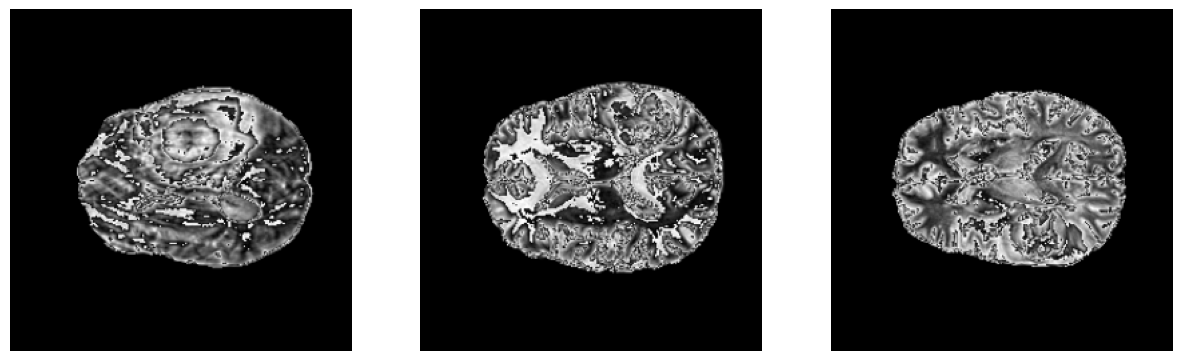

In [10]:
data_iter = iter(brats_trainloader)
images1, images2, images3, tumors1, tumors2, tumors3 = next(data_iter)
random_images = images2[:3]
show_samples(random_images, nrows=1, ncols=3)


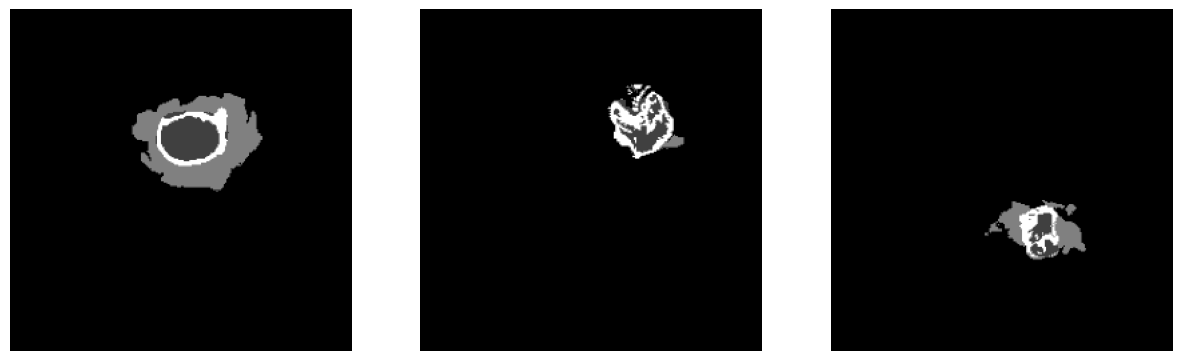

In [11]:
random_images = tumors2[:3]
show_samples(random_images, nrows=1, ncols=3)


In [12]:
from skimage.exposure import match_histograms

def normalize_images(images, new_min=0, new_max=1):
    """
    Normalize images to a new range [new_min, new_max].
    """
    current_min = images.min()
    current_max = images.max()
    # Scale to [0, 1] first, then to [new_min, new_max]
    images = (images - current_min) / (current_max - current_min)  # Scale to [0, 1]
    images = images * (new_max - new_min) + new_min  # Scale to [new_min, new_max]
    return images


def match_histograms_batch(reconstructed_images, target_images):
    """
    Match histograms of reconstructed images to target images.
    """
    matched_images = []
    for recon_img, target_img in zip(reconstructed_images, target_images):
        # Convert tensors to numpy arrays and move to CPU
        recon_img = recon_img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        target_img = target_img.cpu().numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
        # Match histograms
        matched_img = match_histograms(recon_img, target_img, channel_axis=-1)
        matched_images.append(matched_img)
    # Convert back to tensor
    matched_images = torch.tensor(np.stack(matched_images)).permute(0, 3, 1, 2)  # (H, W, C) -> (C, H, W)
    return matched_images

def gamma_correction(images, gamma=1.0):
    """
    Apply gamma correction to images.
    """
    images = torch.pow(images, gamma)
    return images



Real Images:


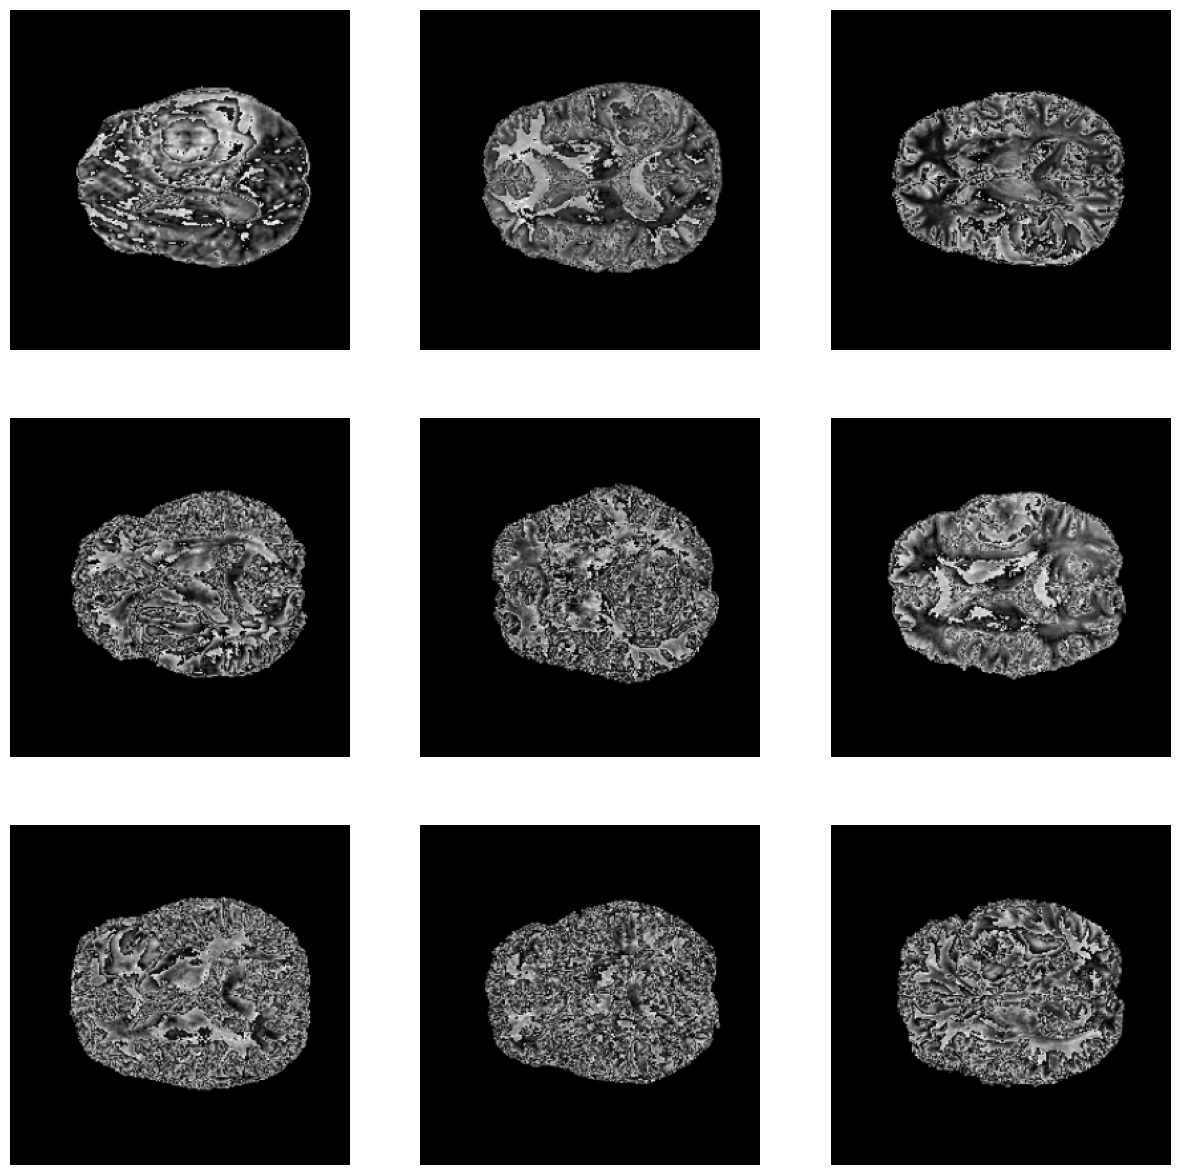

Reconstructed Images:


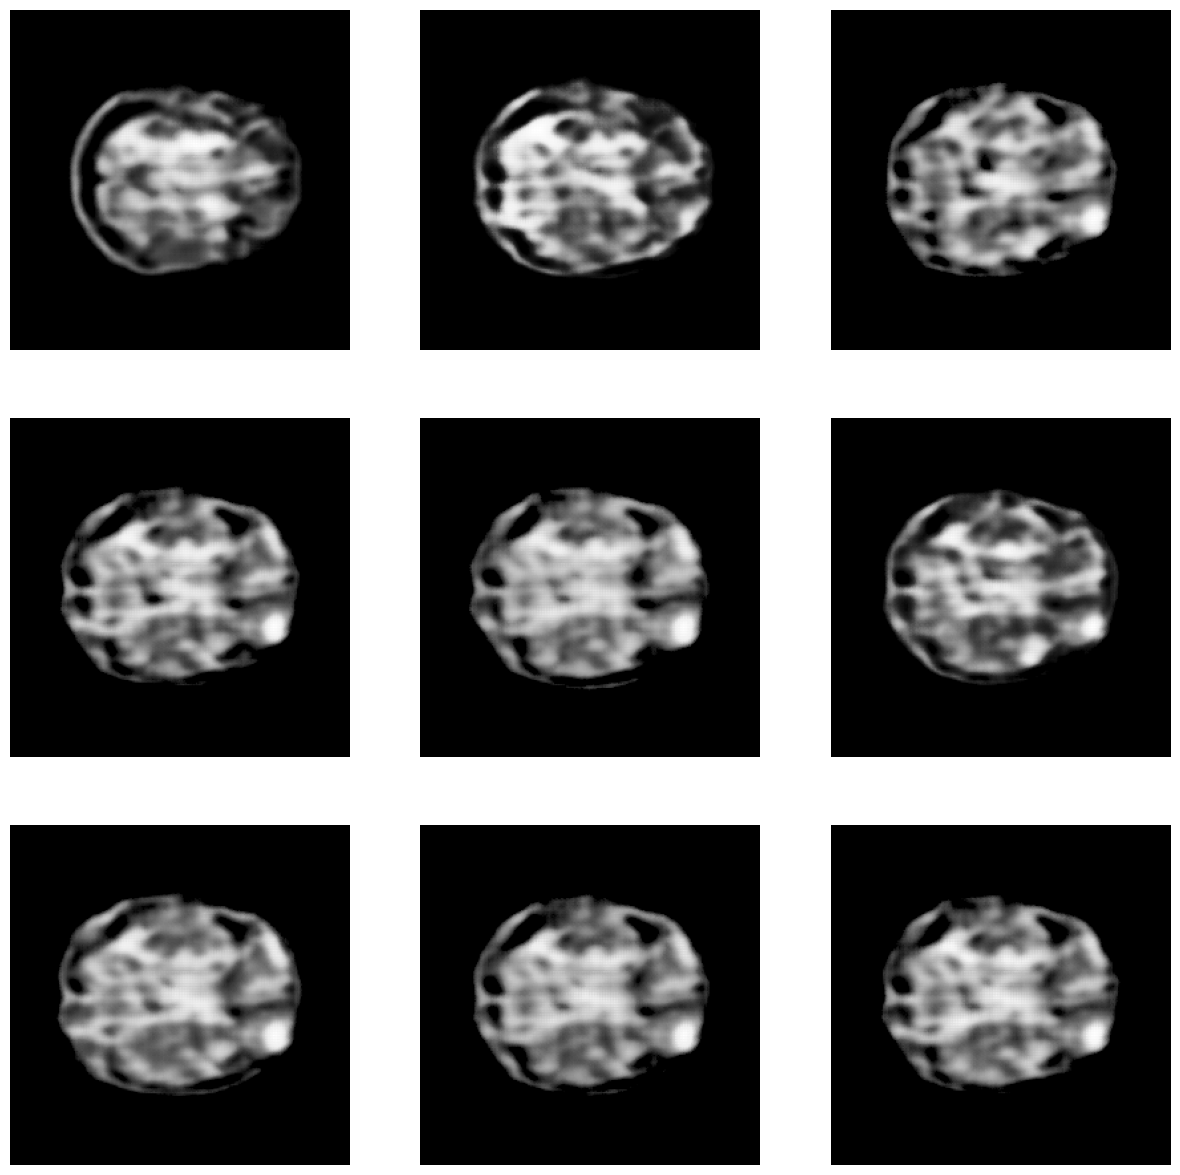

In [14]:
samples = images2.to(device)

with torch.no_grad():
    means, log_vars = vae.encoder(samples)
    decoded_images = vae.decoder(means)

decoded_images_final = match_histograms_batch(decoded_images, samples)
samples_final = match_histograms_batch(samples, decoded_images)

print("Real Images:")
show_samples(samples_final, nrows=3, ncols=3)

print("Reconstructed Images:")
show_samples(decoded_images_final, nrows=3, ncols=3)


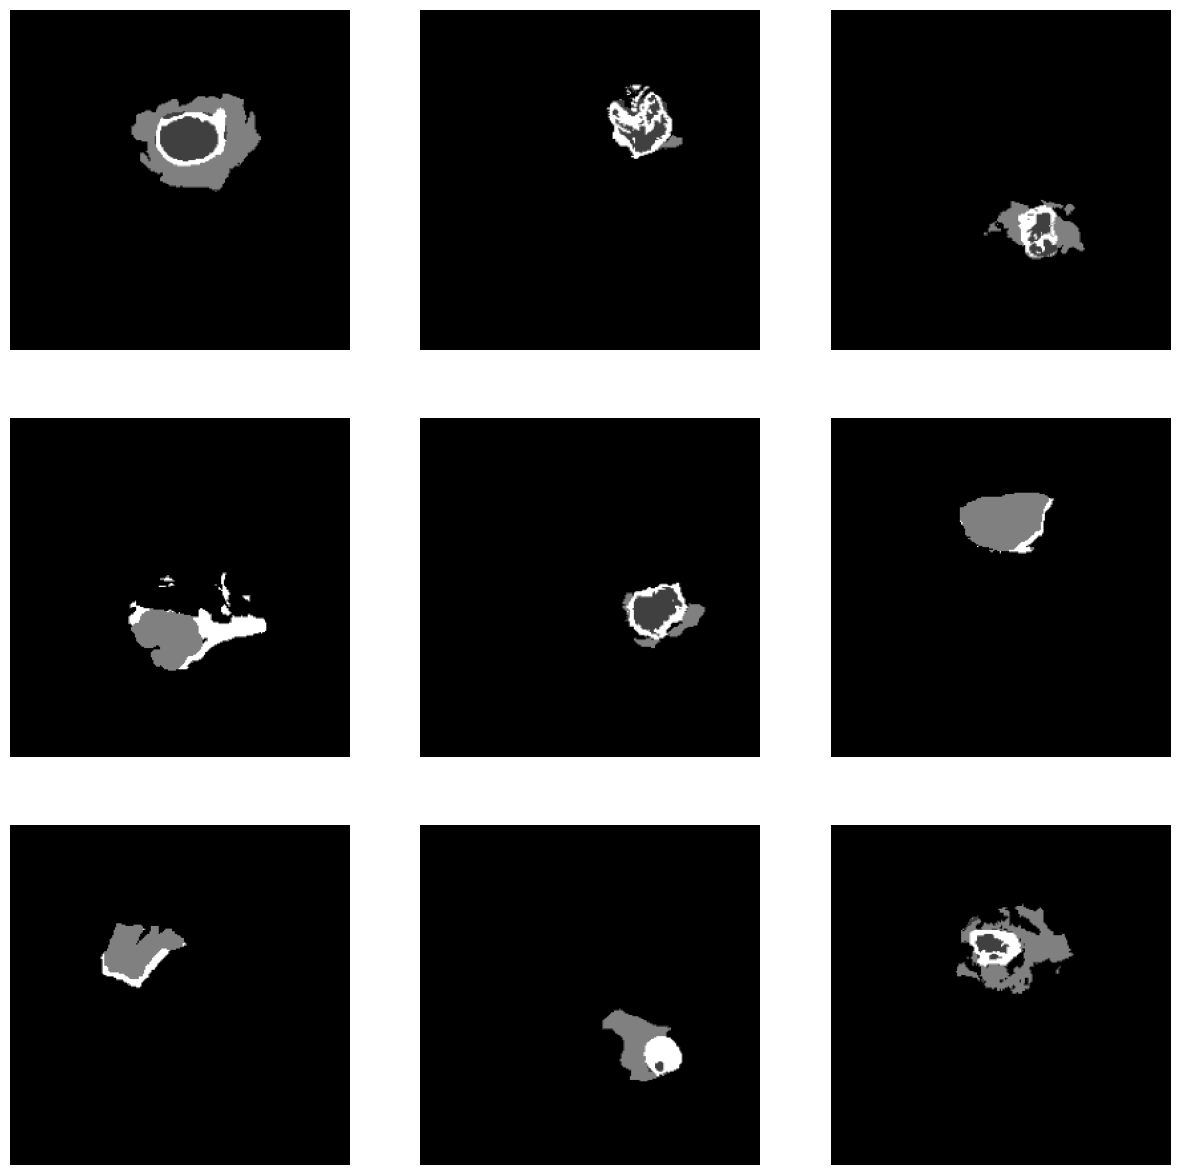

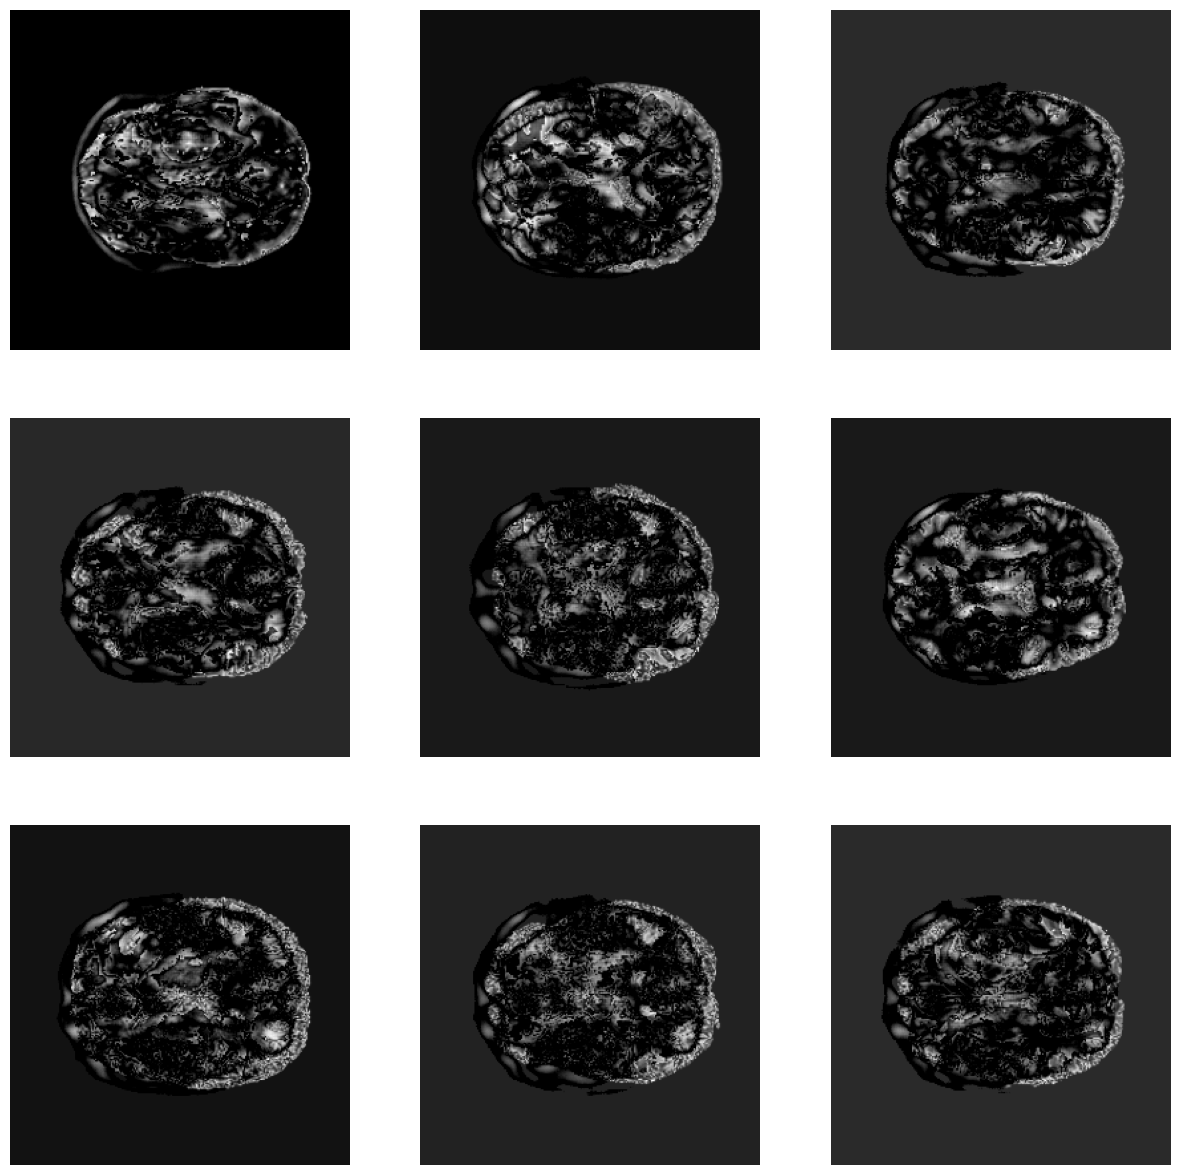

In [15]:
tumor_samples = tumors2.to(device)
show_samples(tumor_samples, nrows=3, ncols=3)

tumors__ = torch.relu(torch.abs(samples_final.cpu() - decoded_images_final.cpu())-0.3)

show_samples(tumors__, nrows=3, ncols=3)


In [83]:
def dice_score(y_true, y_pred, epsilon=1e-6):
    y_true = y_true.float()
    y_pred = y_pred.float()

    intersection = torch.sum(y_true * y_pred, dim=(1, 2, 3))
    union = torch.sum(y_true, dim=(1, 2, 3)) + torch.sum(y_pred, dim=(1, 2, 3))

    dice = (2. * intersection + epsilon) / (union + epsilon)
    return dice.mean().item()

def dice_score_calculator(brats_trainloader, vae):
    dice_scores = []
    
    for images1, images2, images3, tumors1, tumors2, tumors3 in brats_trainloader:
        samples = images2.to(device)
        tumors2 = tumors2.to(device)
    
        with torch.no_grad():
            means, log_vars = vae.encoder(samples)
            decoded_images = vae.decoder(means)
            
        decoded_images = torch.relu(decoded_images-0.1)
        decoded_images = normalize_images(decoded_images, new_min=0, new_max=1)
        # samples = match_histograms_batch(samples, decoded_images)
        samples = normalize_images(samples, new_min=0, new_max=1)
        samples = match_histograms_batch(samples, decoded_images)
        samples = normalize_images(samples, new_min=0, new_max=1)
        
        tumors__ = torch.relu(decoded_images.cpu()-samples.cpu()).cuda()
    
        tumors__ = (tumors__).float()
        # tumors__ = torch.relu(torch.abs(samples - decoded_images)-0.3)
    
        tumors__ = (tumors__).float()
        tumors2 = torch.where(tumors2 > 0, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device)).float()
    
        dice = dice_score(tumors2, tumors__)
        dice_scores.append(dice)
    
        print(f"Batch Dice Score: {dice:.4f}")
    
    mean_dice_score = sum(dice_scores) / len(dice_scores)
    print(f"\nMean Dice Score Across All Batches: {mean_dice_score}")


dice_score_calculator(brats_trainloader, vae)

Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.1111
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000
Batch Dice Score: 0.0000


In [17]:
class TripletDataSet(Dataset):

    def __init__(self, main_path, transform):
        self.main_path = main_path
        self.transform = transform
        self.image_paths = [os.path.join(main_path, case_path, image) for case_path in os.listdir(main_path) for image in os.listdir(os.path.join(main_path, case_path))]
        self.image_paths = self.image_paths[:5000]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx < 4997:
            anchor_image_path = self.image_paths[idx]
            positive_image_path = self.image_paths[idx+1]
            negative_image_path = self.image_paths[idx+2]

        else:
            anchor_image_path = self.image_paths[idx]
            positive_image_path = self.image_paths[idx-1]
            negative_image_path = self.image_paths[idx-2]
        
        anchor_image = Image.open(anchor_image_path)
        positive_image = Image.open(positive_image_path)
        negative_image = Image.open(negative_image_path)

        if self.transform is not None:
            anchor_image = self.transform(anchor_image)
            positive_image = self.transform(positive_image)
            negative_image = self.transform(negative_image)

        return anchor_image, positive_image, negative_image


Triplet_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

Triplet_trainset = TripletDataSet('/kaggle/input/ixit2-slices/image slice-T2', transform=Triplet_transform)
Triplet_trainset, Triplet_valset = train_test_split(Triplet_trainset, test_size=0.2, random_state=42)

triplet_trainloader = DataLoader(Triplet_trainset, batch_size=9, shuffle=True, num_workers=3)
triplet_valloader = DataLoader(Triplet_valset, batch_size=64, shuffle=False, num_workers=3)


In [18]:
import torch.nn.functional as F
import pytorch_ssim

def fixed_ssim(img1, img2, window, window_size, channel, size_average=True):
    """
    A patched version of _ssim function in pytorch_ssim to fix float padding issue and device mismatch.
    """
    device = img1.device
    window = window.to(device)

    mu1 = F.conv2d(img1, window, padding=window_size//2, groups=channel)  # Ensure integer padding
    mu2 = F.conv2d(img2, window, padding=window_size//2, groups=channel)  # Ensure integer padding

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=window_size//2, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=window_size//2, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=window_size//2, groups=channel) - mu1_mu2

    C1 = 0.01 ** 2
    C2 = 0.03 ** 2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) * (sigma1_sq + sigma2_sq + C2))

    return ssim_map.mean() if size_average else ssim_map.mean(1).mean(1).mean(1)

# Override the function in pytorch_ssim
pytorch_ssim._ssim = fixed_ssim


In [19]:
class TripletEncoder(nn.Module):
    def __init__(self, latent_dim=1024):
        super(TripletEncoder, self).__init__()
        self.latent_dim = latent_dim
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2, padding=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, stride=2, padding=2)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=5, stride=2, padding=2)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=5, stride=2, padding=2)        
        self.bn6 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.mean = nn.Linear(8192, 1024)
        self.log_var = nn.Linear(8192, 1024)

        self.dropout = nn.Dropout(p=0.1)

    def forward(self, x):
        batch_size = x.size(0)
        x_1 = self.relu(self.dropout(self.bn1(self.conv1(x))))
        x_2 = self.relu(self.dropout(self.bn2(self.conv2(x_1))))
        x_3 = self.relu(self.dropout(self.bn3(self.conv3(x_2))))
        x = self.relu(self.dropout(self.bn4(self.conv4(x_3))))
        x = self.relu(self.dropout(self.bn5(self.conv5(x))))
        x_6 = self.relu(self.dropout(self.bn6(self.conv6(x))))
        x = x_6.view(batch_size, -1)
        mean = self.mean(x)
        log_var = self.log_var(x)
        return mean, log_var, x_1, x_2, x_3, x_6, x


class TripletDecoder(nn.Module):
    def __init__(self):
        super(TripletDecoder, self).__init__()
        self.fc1 = nn.Linear(1024, 8192)
        self.bn1 = nn.BatchNorm1d(8192)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(p=0.2)
        self.deconv1 = nn.ConvTranspose2d(1024, 256, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn2 = nn.BatchNorm2d(256)
        self.deconv2 = nn.ConvTranspose2d(256, 128, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.deconv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.deconv4 = nn.ConvTranspose2d(128, 32, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn5 = nn.BatchNorm2d(32)
        self.deconv5 = nn.ConvTranspose2d(64, 16, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.bn6 = nn.BatchNorm2d(16)
        self.deconv6 = nn.ConvTranspose2d(32, 1, kernel_size=5, stride=2, padding=2, output_padding=1)
        self.tanh = nn.Tanh()

        self.GCS_enc_conv = nn.Conv2d(64, 64, kernel_size=1)
        self.GCS_dec_conv = nn.Conv2d(64, 64, kernel_size=1)
        self.GCS_beta = nn.Parameter(torch.ones(1))
        self.GCS_tanh = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

    def GCS(self, enc_x, dec_x):
        enc_x = self.GCS_enc_conv(enc_x)
        dec_x = self.GCS_dec_conv(dec_x)

        enc_x = enc_x * torch.tanh(enc_x * dec_x)
        gated_output = (dec_x * self.GCS_beta) + enc_x

        return gated_output

    def forward(self, x, enc_x_1, enc_x_2, enc_x_3, enc_x_6):
        batch_size = x.size(0)
        x = self.relu(self.fc1(x))
        x = x.view(batch_size, 512, 4, 4)
        x = self.relu(self.dropout(self.bn2(self.deconv1(torch.concatenate((x, enc_x_6), dim=1)))))
        x = self.relu(self.dropout(self.bn3(self.deconv2(x))))
        x = self.relu(self.dropout(self.bn4(self.deconv3(x))))
        GCS_gate_output = self.GCS(enc_x_3, x)
        x = self.relu(self.dropout(self.bn5(self.deconv4(torch.concatenate((x, GCS_gate_output), dim=1)))))
        x = self.relu(self.dropout(self.bn6(self.deconv5(torch.concatenate((x, enc_x_2), dim=1)))))
        x = self.tanh(self.deconv6(torch.concatenate((x, enc_x_1), dim=1)))
        return x

import random

def insert_random_noise(image, noise):
    batch_size, channels, img_h, img_w = image.shape  # Get batch size and image dimensions
    _, _, noise_h, noise_w = noise.shape  # Get noise dimensions

    # Generate random top-left corner for noise insertion
    top = random.randint(0, img_h - noise_h)
    left = random.randint(0, img_w - noise_w)

    # Insert noise into image at random location
    image[:, :, top:top + noise_h, left:left + noise_w] += noise

    return torch.clamp(image, 0, 1)
    

class TripletVAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(TripletVAE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.kl_loss_list = []
        self.epoch_loss_list = []
        self.recon_epoch_loss_coarse_list = []
        self.recon_epoch_loss_full_list = []
        self.ssim_epoch_loss_list = []

    def loss_function(self, reconstruction, x, mean, log_var):
        recon_loss = torch.nn.MSELoss(reduction='sum')(reconstruction, x)
        kl_div = (-0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp()) / x.size(0))
        total_loss = recon_loss + kl_div
        return total_loss, kl_div, recon_loss

    def forward(self, x):
        mean, log_var, x_1, x_2, x_3, x_6, x = self.encoder(x)
        z = sampling(mean, log_var)
        reconstruction = self.decoder(z, x_1, x_2, x_3, x_6)
        return reconstruction, mean, log_var, x

    def train_vae(self, train_dataloader, val_dataloader=None, epochs=20, lr=0.0001, device='cuda'):
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        ssim_loss_fn = pytorch_ssim.SSIM(window_size=12)
        criterion = torch.nn.MarginRankingLoss(margin = 1)
        for epoch in range(epochs):
            train_dataloader_with_progress = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}")
            total_epoch_loss, kl_epoch_loss, recon_epoch_loss_coarse, recon_epoch_loss_full, ssim_epoch_loss = 0, 0, 0, 0, 0
            self.train()
            for anchor, positive, negative in train_dataloader_with_progress:
                anchor = anchor.to(device)
                positive = positive.to(device)
                negative = negative.to(device)
                optimizer.zero_grad()         

                noise_16x16 = (torch.randn(anchor.size(0), 1, 16, 16).to(device)) * 0.1
                noise_16x16 = torch.nn.functional.interpolate(noise_16x16, size=(256, 256), mode='bilinear', align_corners=False)
                noise_256x256 = (torch.randn(anchor.size(0), 1, 256, 256).to(device)) * 0.2

                anchor = insert_random_noise(anchor, noise_16x16)
                positive = insert_random_noise(positive, noise_16x16)
                negative = insert_random_noise(negative, noise_16x16)
                negative_256 = negative + noise_256x256
                
                anchor_rec, anchor_mean, anchor_log_var, anchor_emb = self.forward(anchor)
                positive_rec, positive_mean, positive_log_var, positive_emb = self.forward(positive)
                negative_rec, negative_mean, negative_log_var, negative_emb = self.forward(negative)
                negative_rec_256, negative_mean_256, negative_log_var_256, negative_emb_256 = self.forward(negative_256)

                dist_a = torch.nn.functional.pairwise_distance(anchor_emb, positive_emb, 2)
                dist_b = torch.nn.functional.pairwise_distance(anchor_emb, negative_emb, 2)
                
                # 1 means, dist_a should be larger than distb
                target = torch.FloatTensor(dist_a.size()).fill_(1).to(device)
                loss_triplet = criterion(dist_a, dist_b, target)
                
                anchor_loss, anchor_kl_loss, anchor_recon_loss = self.loss_function(anchor_rec, anchor, anchor_mean, anchor_log_var)
                positive_loss, positive_kl_loss, positive_recon_loss = self.loss_function(positive_rec, positive, positive_mean, positive_log_var)
                negative_loss, negative_kl_loss, negative_recon_loss = self.loss_function(negative_rec, negative, negative_mean, negative_log_var)
                negative_loss_256, negative_kl_loss_256, negative_recon_loss_256 = self.loss_function(negative_rec_256, negative_256, negative_mean_256, negative_log_var_256)
                negative_256 = negative_256.float()
                negative_rec_256 = negative_rec_256.float()
                
                ssim_loss = torch.abs(ssim_loss_fn(negative_256, negative_rec_256))
                l1_losses_coarse = anchor_recon_loss + positive_recon_loss + negative_recon_loss
                l1_losses_full = negative_recon_loss_256
                kl_losses = anchor_kl_loss + positive_kl_loss

                loss = l1_losses_coarse + l1_losses_full + kl_losses + loss_triplet + ssim_loss
                
                loss.backward()
                optimizer.step()

                total_epoch_loss += loss.item()
                kl_epoch_loss += kl_losses.item()
                recon_epoch_loss_coarse += l1_losses_coarse.item()
                recon_epoch_loss_full += l1_losses_full.item()
                ssim_epoch_loss += ssim_loss.item()

            total_epoch_loss /= len(train_dataloader)
            kl_epoch_loss /= len(train_dataloader)
            recon_epoch_loss_coarse /= len(train_dataloader)
            recon_epoch_loss_full /= len(train_dataloader)
            ssim_epoch_loss /= len(train_dataloader)
            
            self.epoch_loss_list.append(total_epoch_loss)
            self.kl_loss_list.append(kl_epoch_loss)
            self.recon_epoch_loss_coarse_list.append(recon_epoch_loss_coarse)
            self.recon_epoch_loss_full_list.append(recon_epoch_loss_full)
            self.ssim_epoch_loss_list.append(ssim_epoch_loss)

            print(f"Training - Epoch [{epoch+1}/{epochs}] | Total Loss: {total_epoch_loss:.4f} | KL Loss: {kl_epoch_loss:.4f} | Coarse Recon Loss: {recon_epoch_loss_coarse:.4f} | Full Recon Loss: {recon_epoch_loss_full:.4f} | SSIM Loss:{ssim_epoch_loss:.4f}")

        plot_loss(self.epoch_loss_list, "Training Total Loss")
        plot_loss(self.kl_loss_list, "Training KL Loss")
        plot_loss(self.recon_epoch_loss_coarse_list, "Training Coarse Reconstruction Loss")
        plot_loss(self.recon_epoch_loss_full_list, "Training Full Reconstruction Loss")
        plot_loss(self.ssim_epoch_loss_list, "Training SSIM Loss")


Epoch 1/20: 100%|██████████| 445/445 [00:46<00:00,  9.49it/s]


Training - Epoch [1/20] | Total Loss: 189621.6315 | KL Loss: 1286.2196 | Coarse Recon Loss: 81524.6351 | Full Recon Loss: 106797.0694 | SSIM Loss:0.0651


Epoch 2/20: 100%|██████████| 445/445 [00:46<00:00,  9.54it/s]


Training - Epoch [2/20] | Total Loss: 67382.5162 | KL Loss: 727.8675 | Coarse Recon Loss: 26661.3811 | Full Recon Loss: 39979.2472 | SSIM Loss:0.1973


Epoch 3/20: 100%|██████████| 445/445 [00:46<00:00,  9.49it/s]


Training - Epoch [3/20] | Total Loss: 33514.0769 | KL Loss: 178.0839 | Coarse Recon Loss: 13140.9526 | Full Recon Loss: 20180.5467 | SSIM Loss:0.3390


Epoch 4/20: 100%|██████████| 445/445 [00:46<00:00,  9.53it/s]


Training - Epoch [4/20] | Total Loss: 19926.0191 | KL Loss: 175.9972 | Coarse Recon Loss: 7394.6196 | Full Recon Loss: 12341.0121 | SSIM Loss:0.4626


Epoch 5/20: 100%|██████████| 445/445 [00:46<00:00,  9.51it/s]


Training - Epoch [5/20] | Total Loss: 13615.5923 | KL Loss: 99.0895 | Coarse Recon Loss: 4682.1465 | Full Recon Loss: 8820.9768 | SSIM Loss:0.5526


Epoch 6/20: 100%|██████████| 445/445 [00:46<00:00,  9.51it/s]


Training - Epoch [6/20] | Total Loss: 10386.8243 | KL Loss: 69.3996 | Coarse Recon Loss: 3306.9439 | Full Recon Loss: 6996.9790 | SSIM Loss:0.6152


Epoch 7/20: 100%|██████████| 445/445 [00:46<00:00,  9.52it/s]


Training - Epoch [7/20] | Total Loss: 8545.7429 | KL Loss: 66.6814 | Coarse Recon Loss: 2545.4395 | Full Recon Loss: 5920.4036 | SSIM Loss:0.6589


Epoch 8/20: 100%|██████████| 445/445 [00:46<00:00,  9.55it/s]


Training - Epoch [8/20] | Total Loss: 7380.8228 | KL Loss: 51.1856 | Coarse Recon Loss: 2107.7324 | Full Recon Loss: 5209.5509 | SSIM Loss:0.6909


Epoch 9/20: 100%|██████████| 445/445 [00:46<00:00,  9.51it/s]


Training - Epoch [9/20] | Total Loss: 6589.5480 | KL Loss: 40.2960 | Coarse Recon Loss: 1828.1301 | Full Recon Loss: 4709.5969 | SSIM Loss:0.7155


Epoch 10/20: 100%|██████████| 445/445 [00:46<00:00,  9.54it/s]


Training - Epoch [10/20] | Total Loss: 6049.1817 | KL Loss: 41.2388 | Coarse Recon Loss: 1647.5475 | Full Recon Loss: 4349.0977 | SSIM Loss:0.7325


Epoch 11/20: 100%|██████████| 445/445 [00:46<00:00,  9.53it/s]


Training - Epoch [11/20] | Total Loss: 5624.2518 | KL Loss: 41.7888 | Coarse Recon Loss: 1509.5870 | Full Recon Loss: 4061.9115 | SSIM Loss:0.7480


Epoch 12/20: 100%|██████████| 445/445 [00:46<00:00,  9.52it/s]


Training - Epoch [12/20] | Total Loss: 5356.0649 | KL Loss: 74.0339 | Coarse Recon Loss: 1437.0923 | Full Recon Loss: 3835.0362 | SSIM Loss:0.7585


Epoch 13/20: 100%|██████████| 445/445 [00:46<00:00,  9.54it/s]


Training - Epoch [13/20] | Total Loss: 5048.8749 | KL Loss: 25.3615 | Coarse Recon Loss: 1376.7752 | Full Recon Loss: 3637.7762 | SSIM Loss:0.7687


Epoch 14/20: 100%|██████████| 445/445 [00:46<00:00,  9.54it/s]


Training - Epoch [14/20] | Total Loss: 4816.3465 | KL Loss: 27.5986 | Coarse Recon Loss: 1321.9571 | Full Recon Loss: 3458.4281 | SSIM Loss:0.7804


Epoch 15/20: 100%|██████████| 445/445 [00:46<00:00,  9.53it/s]


Training - Epoch [15/20] | Total Loss: 4610.8528 | KL Loss: 31.6817 | Coarse Recon Loss: 1283.8890 | Full Recon Loss: 3287.6292 | SSIM Loss:0.7884


Epoch 16/20: 100%|██████████| 445/445 [00:46<00:00,  9.57it/s]


Training - Epoch [16/20] | Total Loss: 4369.9267 | KL Loss: 20.8274 | Coarse Recon Loss: 1231.7677 | Full Recon Loss: 3110.1896 | SSIM Loss:0.7984


Epoch 17/20: 100%|██████████| 445/445 [00:46<00:00,  9.52it/s]


Training - Epoch [17/20] | Total Loss: 4171.3761 | KL Loss: 21.0496 | Coarse Recon Loss: 1203.7872 | Full Recon Loss: 2939.7662 | SSIM Loss:0.8056


Epoch 18/20: 100%|██████████| 445/445 [00:46<00:00,  9.48it/s]


Training - Epoch [18/20] | Total Loss: 3952.4743 | KL Loss: 18.2330 | Coarse Recon Loss: 1162.8816 | Full Recon Loss: 2765.1278 | SSIM Loss:0.8126


Epoch 19/20: 100%|██████████| 445/445 [00:46<00:00,  9.53it/s]


Training - Epoch [19/20] | Total Loss: 3754.7851 | KL Loss: 13.8881 | Coarse Recon Loss: 1127.5506 | Full Recon Loss: 2607.6388 | SSIM Loss:0.8180


Epoch 20/20: 100%|██████████| 445/445 [00:46<00:00,  9.51it/s]

Training - Epoch [20/20] | Total Loss: 3606.6920 | KL Loss: 15.4264 | Coarse Recon Loss: 1104.9840 | Full Recon Loss: 2480.6345 | SSIM Loss:0.8211


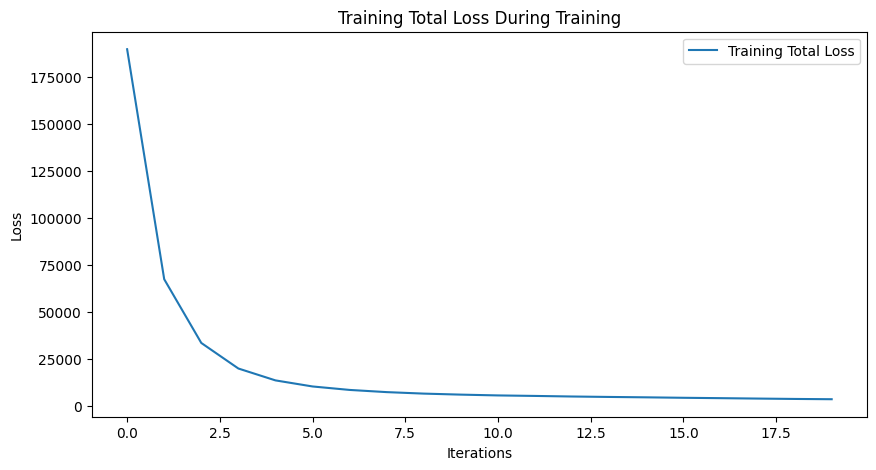

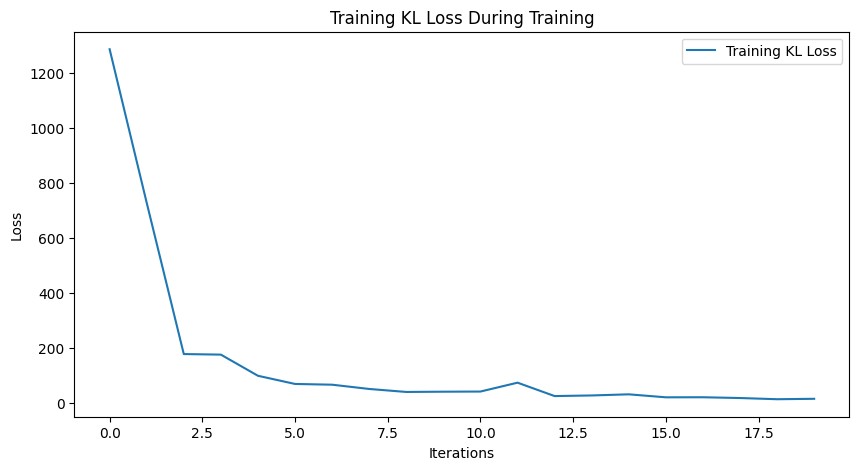

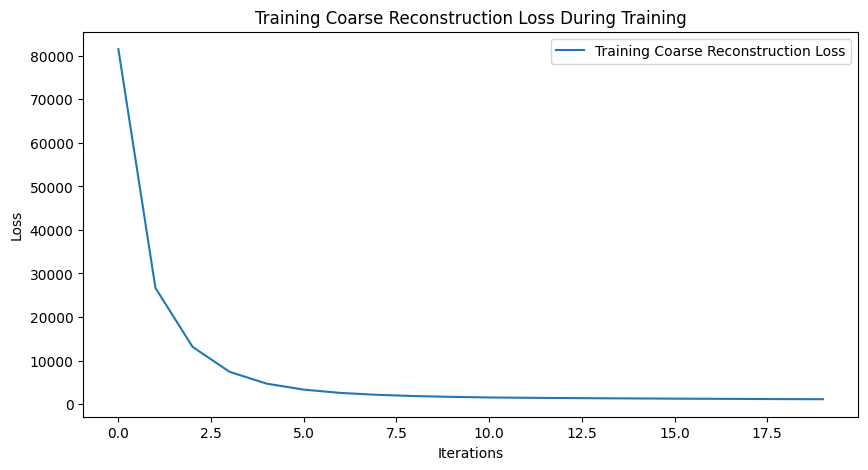

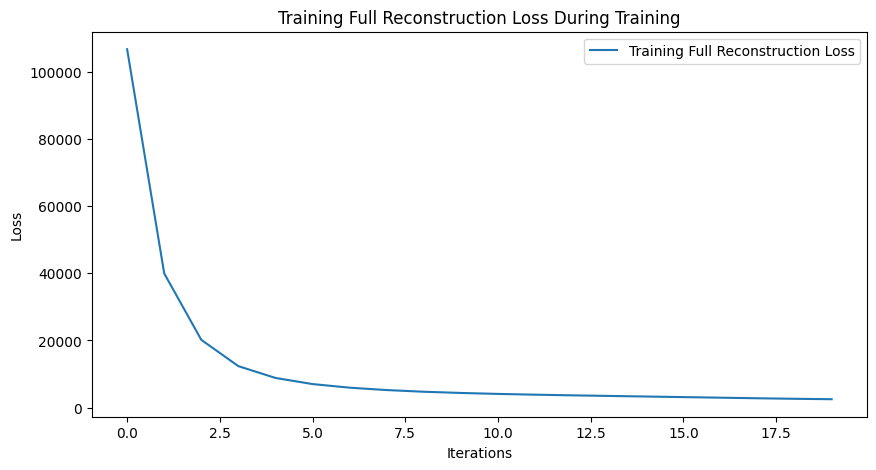

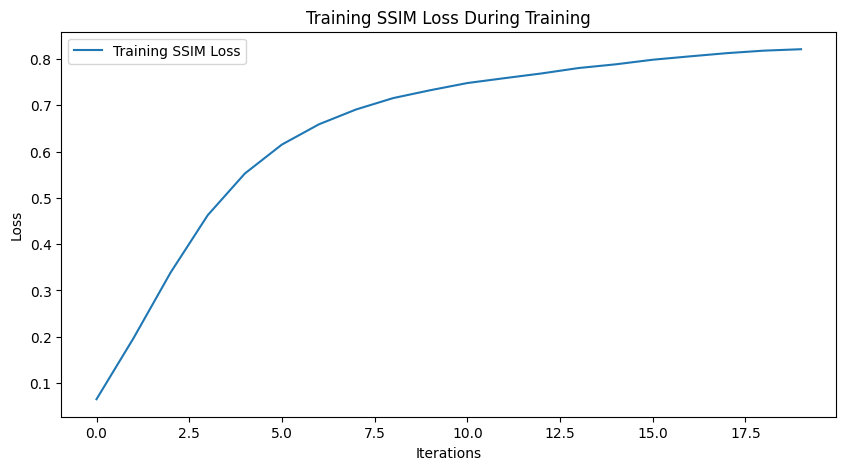

Model saved to ./vae_model.pth


In [20]:
triplet_encoder = TripletEncoder().to(device)
triplet_decoder = TripletDecoder().to(device)
triplet_vae = TripletVAE(triplet_encoder, triplet_decoder).to(device)

triplet_vae.train_vae(triplet_trainloader, triplet_valloader)

save_model(triplet_vae)


Real Images:


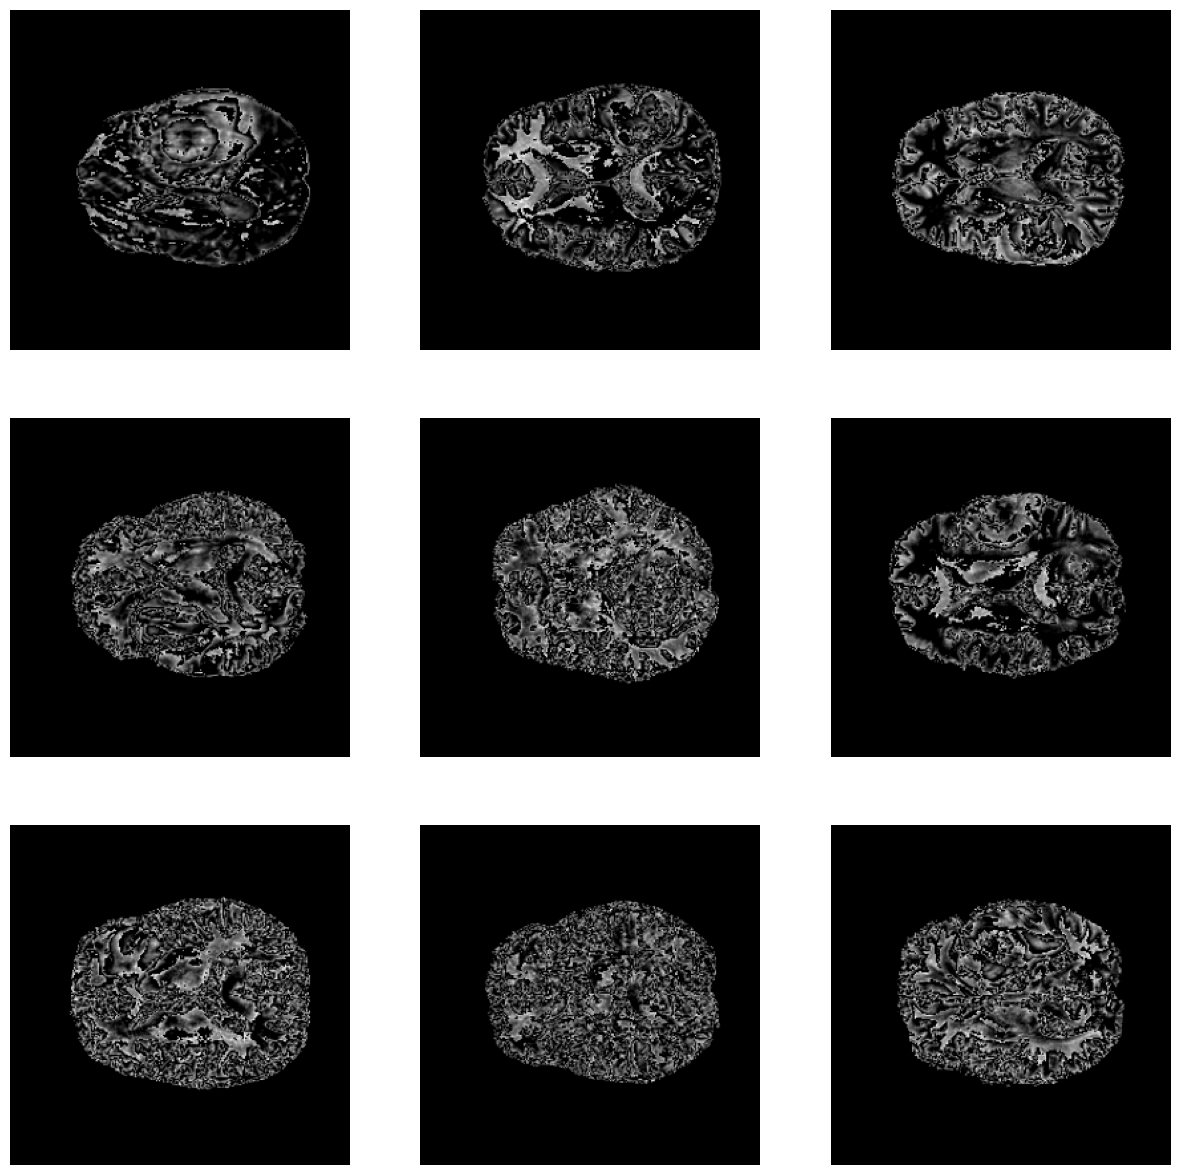

Reconstructed Images:


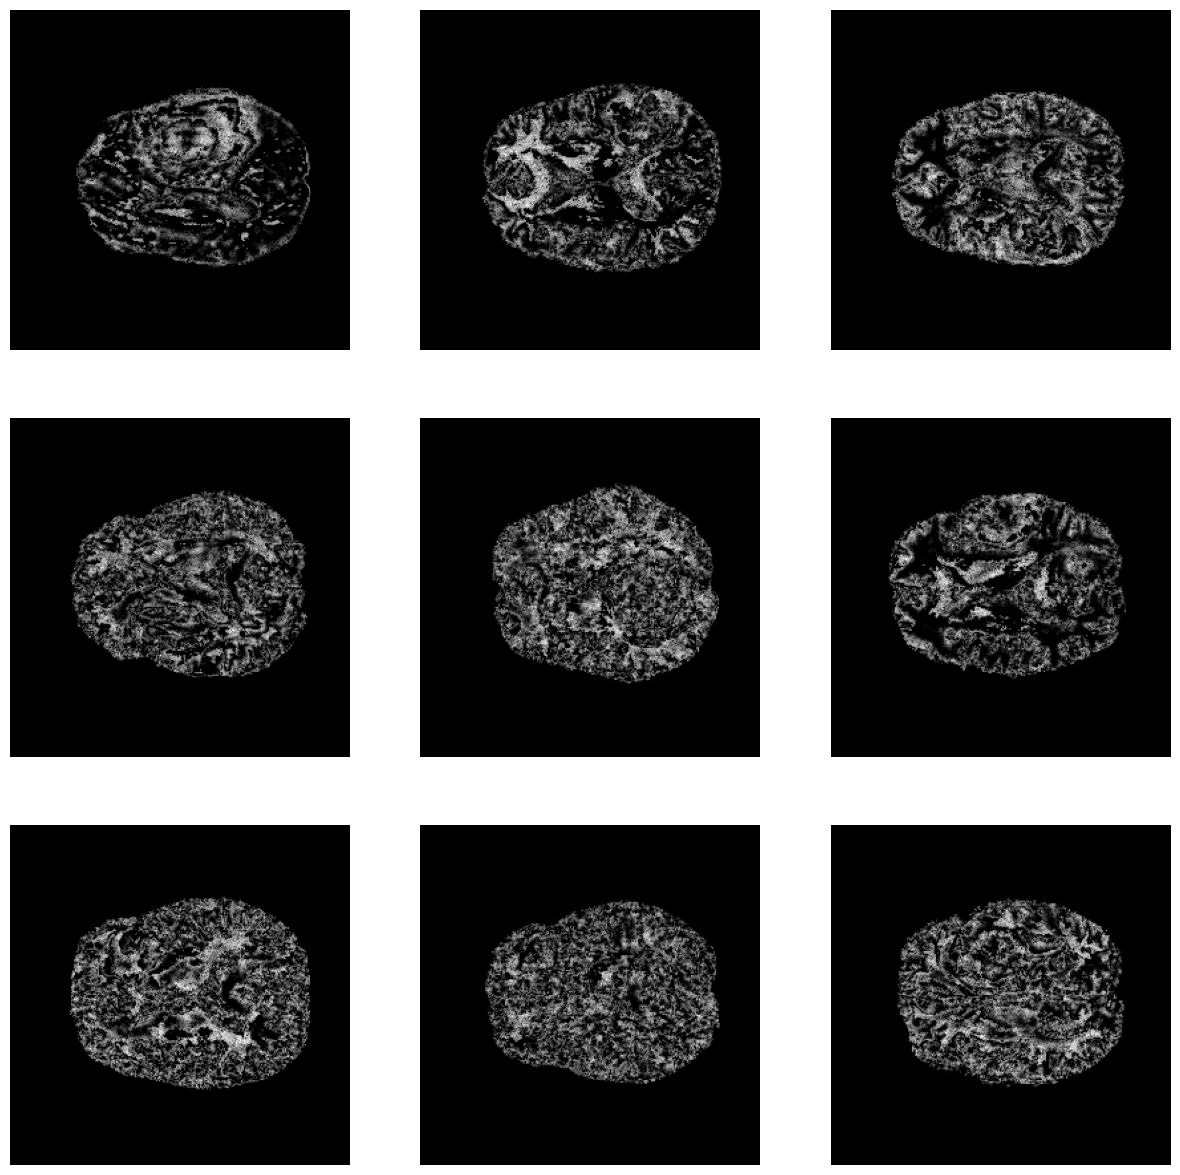

In [48]:
# Move the image tensor to the same device as the model
samples = images2.to(device)  # Move to GPU or CPU based on availability

# Pass the image through the VAE
with torch.no_grad():
    means, log_vars, enc_x_1, enc_x_2, enc_x_3, enc_x_6, x = triplet_vae.encoder(samples)
    decoded_images = triplet_vae.decoder(means, enc_x_1, enc_x_2, enc_x_3, enc_x_6)

decoded_images = torch.relu(decoded_images-0.1)
# decoded_images_final = match_histograms_batch(decoded_images, samples)
samples_final = match_histograms_batch(samples, decoded_images)

print("Real Images:")
show_samples(samples_final, nrows=3, ncols=3)

print("Reconstructed Images:")
show_samples(decoded_images, nrows=3, ncols=3)

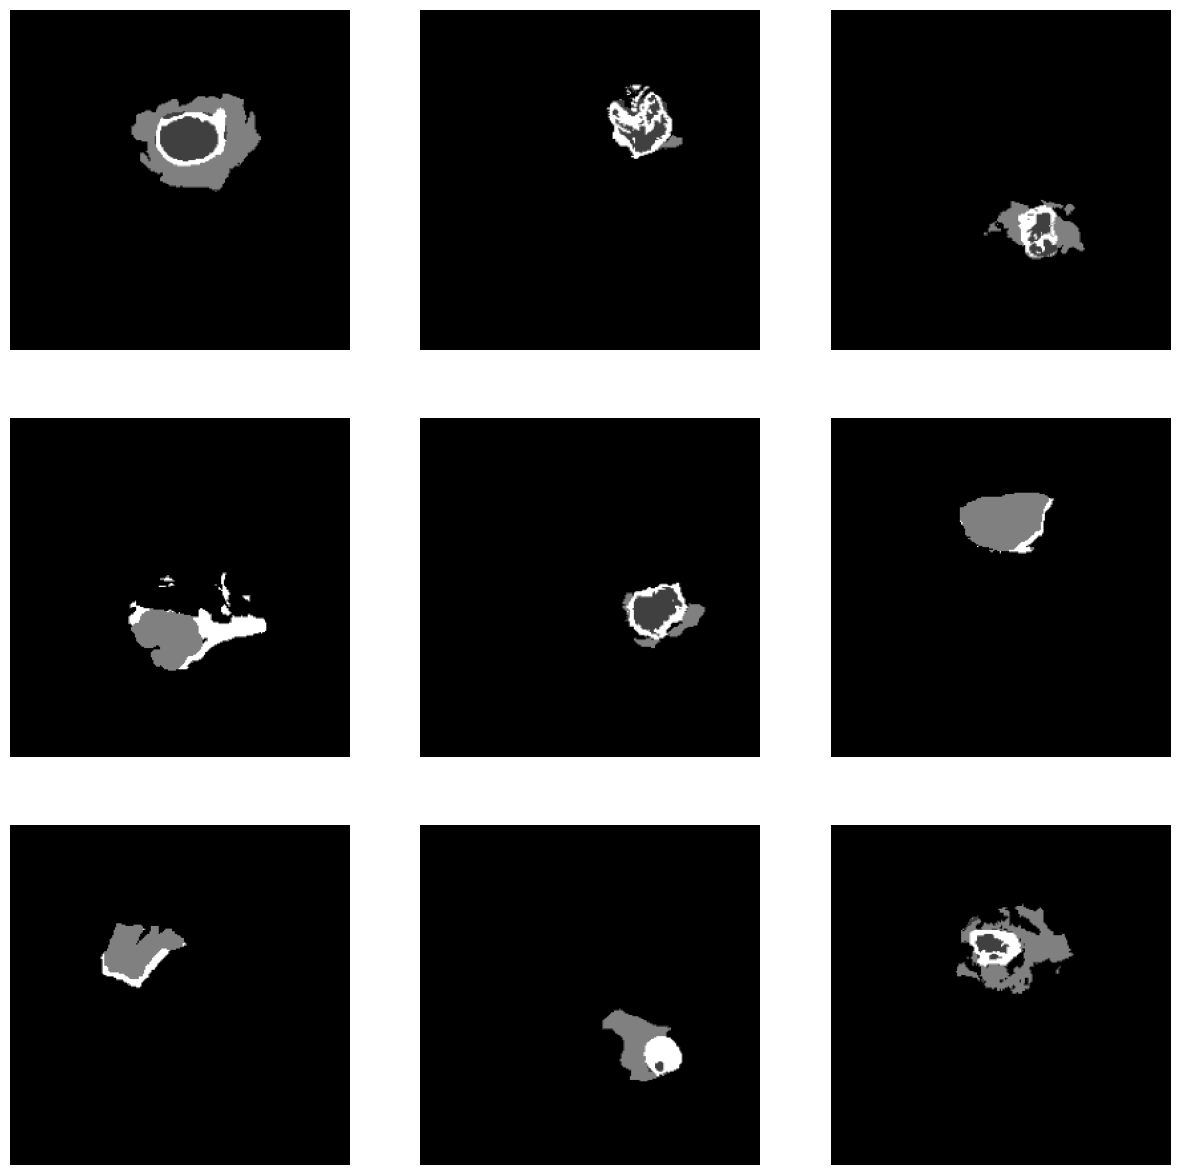

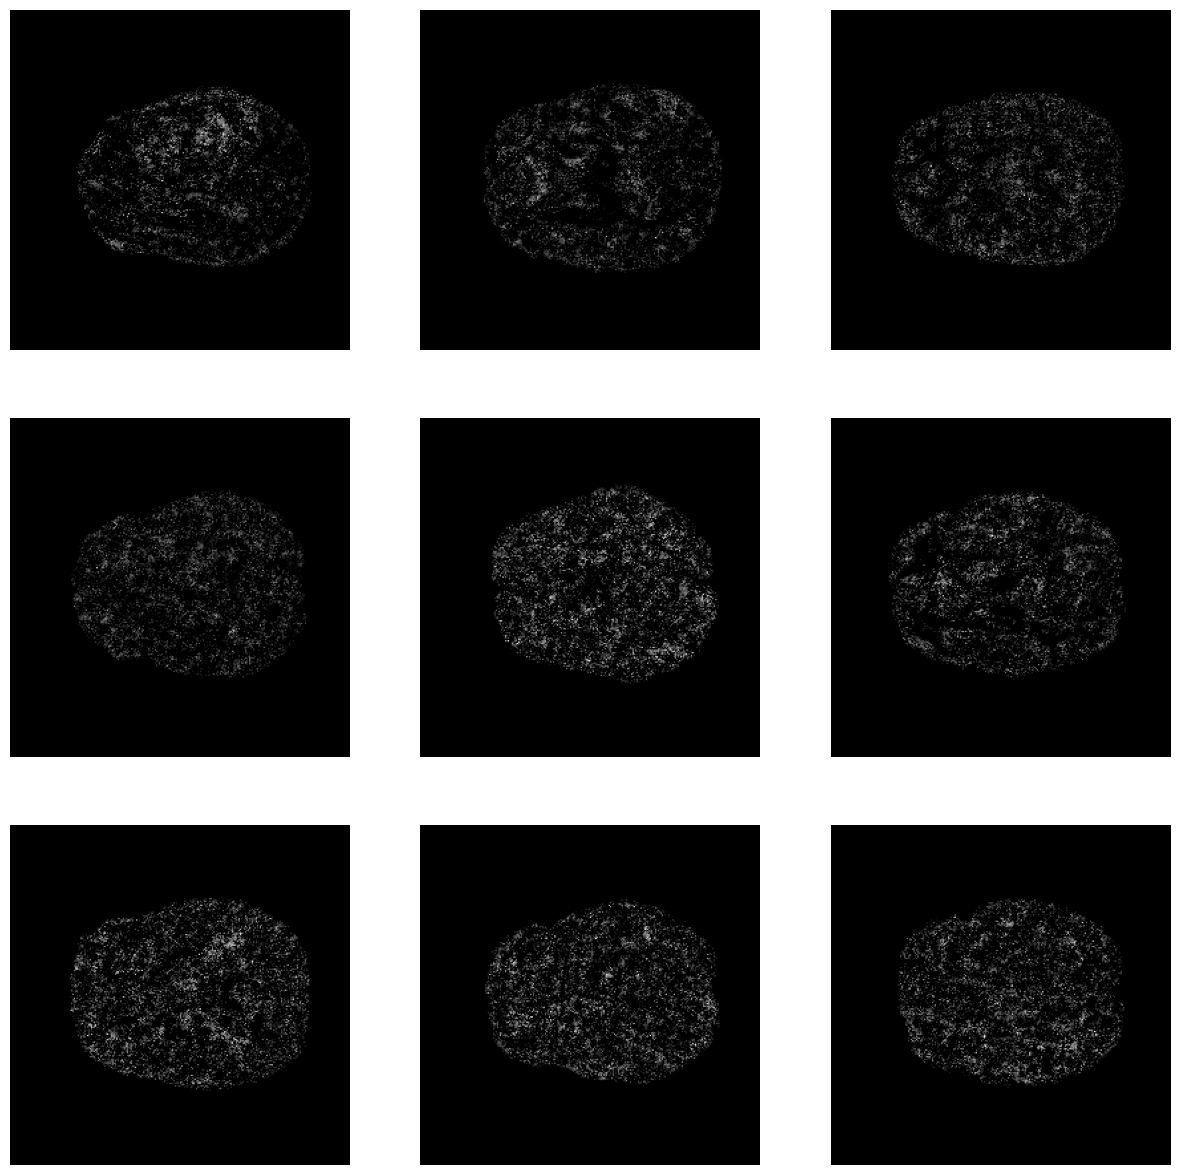

In [76]:
tumor_samples = tumors2.to(device)
show_samples(tumor_samples, nrows=3, ncols=3)

tumors____ = torch.relu(decoded_images.cpu()-samples_final.cpu())

show_samples(tumors____, nrows=3, ncols=3)


In [81]:
dice_scores = []

def triplet_vae_dice_scoer(brats_trainloader):
    for images1, images2, images3, tumors1, tumors2, tumors3 in brats_trainloader:
        samples = images2.to(device)
        tumors2 = tumors2.to(device)
    
        with torch.no_grad():
            means, log_vars, enc_x_1, enc_x_2, enc_x_3, enc_x_6, x = triplet_vae.encoder(samples)
            decoded_images = triplet_vae.decoder(means, enc_x_1, enc_x_2, enc_x_3, enc_x_6)

        decoded_images = torch.relu(decoded_images-0.1)
        decoded_images = normalize_images(decoded_images, new_min=0, new_max=1)
        # samples = match_histograms_batch(samples, decoded_images)
        samples = normalize_images(samples, new_min=0, new_max=1)
        samples = match_histograms_batch(samples, decoded_images)
        samples = normalize_images(samples, new_min=0, new_max=1)
        
        tumors__ = torch.relu(decoded_images.cpu()-samples.cpu()).cuda()
    
        tumors__ = (tumors__).float()
        # tumors2 = torch.where(tumors2 > 0, torch.tensor(1.0).to(device), torch.tensor(0.0).to(device)).float()

        dice = dice_score(tumors2, tumors__)
        dice_scores.append(dice)
    
        print(f"Batch Dice Score: {dice}")

    mean_dice_score = sum(dice_scores) / len(dice_scores)
    print(f"\nTriplet VAE Mean Dice Score Across All Batches: {mean_dice_score}")

triplet_vae_dice_scoer(brats_trainloader)


Batch Dice Score: 0.020834142342209816
Batch Dice Score: 0.020787203684449196
Batch Dice Score: 0.021749403327703476
Batch Dice Score: 0.021089604124426842
Batch Dice Score: 0.021606115624308586
Batch Dice Score: 0.01973416469991207
Batch Dice Score: 0.021748770028352737
Batch Dice Score: 0.023403704166412354
Batch Dice Score: 0.01969655230641365
Batch Dice Score: 0.022937161847949028
Batch Dice Score: 0.019685868173837662
Batch Dice Score: 0.01888910122215748
Batch Dice Score: 0.019661249592900276
Batch Dice Score: 0.02125832810997963
Batch Dice Score: 0.02142948843538761
Batch Dice Score: 0.021066725254058838
Batch Dice Score: 0.01829381287097931
Batch Dice Score: 0.01956760883331299
Batch Dice Score: 0.021038660779595375
Batch Dice Score: 0.01938832551240921
Batch Dice Score: 0.021073007956147194
Batch Dice Score: 0.01913520134985447
Batch Dice Score: 0.021796580404043198
Batch Dice Score: 0.020171042531728745
Batch Dice Score: 0.020537443459033966
Batch Dice Score: 0.01974251493811